In [2]:
import json
import pandas as pd
from sklearn.metrics import silhouette_score,calinski_harabasz_score,pairwise_distances
from Kernels.src.Analysis.Clustering import *
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score
import itertools
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.mosaicplot import mosaic
import lifelines
import statsmodels.api as sm
import itertools
from scipy import stats
import plotly.graph_objects as go
from matplotlib.offsetbox import AnchoredText
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.colorbar as cb


### Set plot params


In [3]:
fontPath = "/CTGlab/home/danilo/.fonts/arial.ttf" 
#From seaborn#########
sns.set_context("paper")
sns.set_style("whitegrid")
#sns.set(font='Helvetica')

#From matplotlib########
#Font:
prop = fm.FontProperties(fname=fontPath)
fm.fontManager.addfont(fontPath)
plt.rcParams['font.family'] = prop.get_name()
#plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.labelspacing'] = 1.5
plt.rcParams['legend.fontsize'] = 14
# Disable LaTeX interpreter
plt.rcParams['text.usetex'] = False

#lines:
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
#plt.rcParams['axes.edgecolor'] = '#353935'
 



# Load and Parse data

In [4]:
data_input = pd.read_csv("Input_data/UMAP_METABRIC_4cmp_IC10_full.csv", sep = ",",index_col=0)
data_input=data_input.sample(n=100,axis=0,random_state=42)
df_new_clust=pd.DataFrame()
df_new_clust.index=data_input.index

In [5]:
#get classical kernel
#SELECT FT
n_qubits=4
features=[]
for i in range(1,int(n_qubits)+1):
    name_cna='Component_'+str(i)
    features.append(name_cna)
labels = 'IntClustMemb'
print(features)

########SAMPLING###################################
y_train=data_input[labels].to_numpy()
X_train=data_input[features]

['Component_1', 'Component_2', 'Component_3', 'Component_4']


In [6]:
outdir='/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_umap_100_hardware/Mumbai_CU/'
df_real=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_umap_100_hardware/Mumbai_CU/clustering_100_opt_k_reviewed.csv')
df_sim=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_100_umap/clustering_100_opt_k_reviewed.csv')
df_sim_1000=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_1000_umap/clustering_1000_opt_k_reviewed.csv')
df_2000=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_2000_umap/clustering_1980_opt_k_reviewed.csv')

In [7]:
#map bandwidth
df_sim_1000[r'$\beta$']=df_sim_1000.Bandwidth.map({0.125:r'$\frac{\pi}{8}$',0.25:r'$\frac{\pi}{4}$',0.5:r'$\frac{\pi}{2}$',1:r'$\pi$',2:r'$2\pi$'})
df_2000[r'$\beta$']=df_2000.Bandwidth.map({0.125:r'$\frac{\pi}{8}$',0.25:r'$\frac{\pi}{4}$',0.5:r'$\frac{\pi}{2}$',1:r'$\pi$',2:r'$2\pi$'})
#remove rbf with bandwidth !=1
df_sim_1000.drop(df_sim_1000[(df_sim_1000.ftmap=='rbf') & (df_sim_1000.Bandwidth!=1)].index,inplace=True)
df_2000.drop(df_2000[(df_2000.ftmap=='rbf') & (df_2000.Bandwidth!=1)].index,inplace=True)
#map rbf beta to 1
df_sim_1000.loc[df_sim_1000.ftmap=='rbf',r'$\beta$']='1'
df_2000.loc[df_2000.ftmap=='rbf',r'$\beta$']='1'

In [8]:
df_2000

Unnamed: 0      ftmap   K  Bandwidth              s  geom_distance  \
27           27        rbf   2        1.0  126427.404049       2.459801   
28           28        rbf   3        1.0  126427.404049       2.459801   
29           29        rbf   4        1.0  126427.404049       2.459801   
30           30        rbf   5        1.0  126427.404049       2.459801   
31           31        rbf   6        1.0  126427.404049       2.459801   
..          ...        ...  ..        ...            ...            ...   
175         175  ZZ_linear   6        2.0  142283.151697      35.370720   
176         176  ZZ_linear   7        2.0  142283.151697      35.370720   
177         177  ZZ_linear   8        2.0  142283.151697      35.370720   
178         178  ZZ_linear   9        2.0  142283.151697      35.370720   
179         179  ZZ_linear  10        2.0  142283.151697      35.370720   

     concentration  silhouette  Score_cluster          CHI        DI  \
27        0.028149    0.541753       0.548029  1323.383994  0.000420   
28        0.028149    0.568687       0.612915  1002.217980  0.000669   
29        0.028149    0.427324       0.615735  1054.539243  0.000872   
30        0.028149    0.414847       0.655101  1030.559094  0.000728   
31        0.028149    0.408590       0.687778   949.856227  0.000577   
..             ...         ...            ...          ...       ...   
175       0.012055    0.057790       0.089948    41.112759  0.048057   
176       0.012055    0.062091       0.100920    32.777881  0.052108   
177       0.012055    0.068919       0.113717    35.198769  0.051035   
178       0.012055    0.076932       0.119561    43.622137  0.047041   
179       0.012055    0.078305       0.125044    40.267353  0.051040   

      v_intra   v_inter  N_samples $\beta$  
27   0.017752  0.024397       1980       1  
28   0.008163  0.030924       1980       1  
29   0.005637  0.030072       1980       1  
30   0.004759  0.028514       1980       1  
31   0.004185  0.027981       1980       1  
..        ...       ...        ...     ...  
175  0.024311  0.006531       1980  $2\pi$  
176  0.026224  0.006588       1980  $2\pi$  
177  0.028806  0.006646       1980  $2\pi$  
178  0.030147  0.006621       1980  $2\pi$  
179  0.032127  0.006694       1980  $2\pi$  

[144 rows x 15 columns]

In [9]:

#Tag simulated and real data
df_real['Type']=['Real']*len(df_real)
df_sim['Type']=['Simulated']*len(df_sim)
df_sim_1000['Type']=['Simulated']*len(df_sim_1000)
#Coherent notation
df_real.replace('Z_full','Z',inplace=True)
df_sim.replace('Z_full','Z',inplace=True)
df_sim_1000.replace('Z_full','Z',inplace=True)
df_2000.replace('Z_full','Z',inplace=True)



In [10]:
df= pd.concat([df_sim, df_real], axis=0, ignore_index=True)

In [11]:
df_sim_tot=pd.concat([df_sim,df_sim_1000],axis=0,ignore_index=True)

In [12]:
df.replace('Z_full','Z',inplace=True)


(0.0, 1.0)

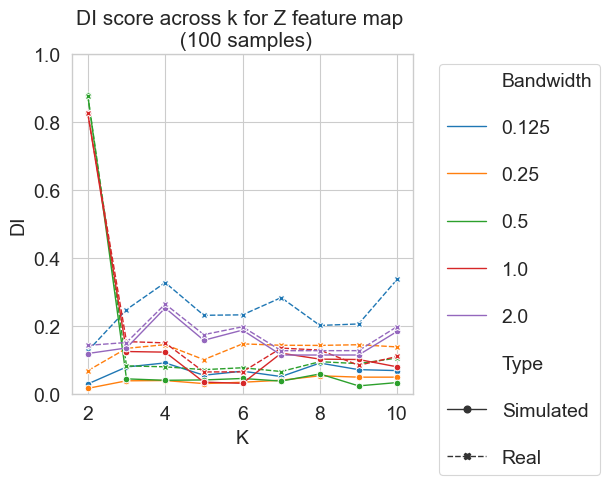

In [13]:

ft_map_to_plot='Z'
score_to_plot='DI'


sns.lineplot(data=df[df['ftmap'].isin([ft_map_to_plot])],
             x='K',y=score_to_plot,style='Type',hue='Bandwidth',markers=True,palette='tab10')


# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('{} score across k for {} feature map \n ({} samples)'.format(score_to_plot,ft_map_to_plot,df.N_samples[0]))
plt.tight_layout()
plt.ylim(0,1)
# Show the plot
#plt.savefig(outdir+'{}_ftmap_coherence_{}_score.png'.format(ft_map_to_plot,score_to_plot))


# Plots for paper

In [14]:
dir_paper='/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/images/paper/'

To do :
- SS trend 100 and 1000 sim togheter
- DI trend 100 and 1000 sim togheter
- different K 
- coherence different ftmap

In [15]:
#order by ftmap
df_sim_tot.sort_values(by=['ftmap'],ascending=True,inplace=True)

In [16]:

label_x=[r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\pi$', r'$2\pi$']


In [17]:
score='silhouette'

([<matplotlib.axis.XTick at 0x7f2dfa9eeaf0>,
 [Text(0.125, 0, '$\\frac{\\pi}{8}$'),
  Text(0.25, 0, '$\\frac{\\pi}{4}$'),
  Text(0.5, 0, '$\\frac{\\pi}{2}$'),
  Text(1.0, 0, '$\\pi$'),
  Text(2.0, 0, '$2\\pi$')])

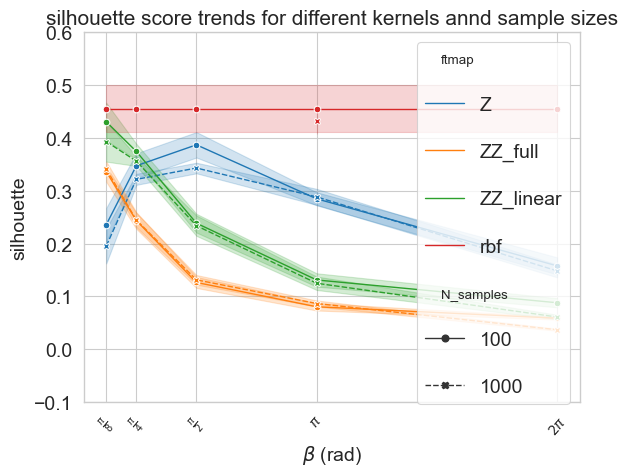

In [18]:




# Plot silhouette trend 1000 and 100
sns.lineplot(data=df_sim_tot,x='Bandwidth',
             y= score ,hue='ftmap',markers=True,style='N_samples', errorbar='se')
plt.ylim(-0.1,0.6)
plt.xlabel(r'$\beta$ (rad)')
plt.title('{} score trends for different kernels annd sample sizes'.format(score))
plt.xticks(ticks =[0.125,0.25,0.5,1,2] ,labels = label_x, rotation = 50, fontsize = 10)

#plt.savefig(dir_paper+'{}_trend_100_1000.png'.format(score),dpi=300)




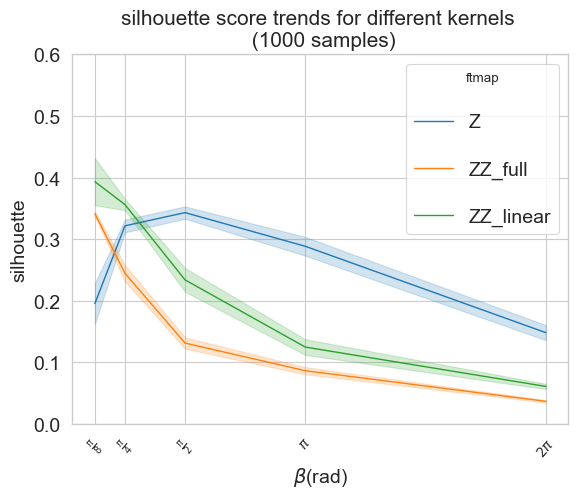

In [19]:
# Disable LaTeX interpreter
plt.rcParams['text.usetex'] = False

# Plot silhouette trend 
sns.lineplot(data=df_sim_tot[(df_sim_tot.N_samples==1000) &(df_sim_tot.ftmap != 'rbf')],x='Bandwidth',
             y=score,hue='ftmap',errorbar='se')
plt.xlabel(r'$\beta$(rad)')
plt.title('{} score trends for different kernels \n (1000 samples)'.format(score))
plt.xticks(ticks = [0.125,0.25,0.5,1,2] ,labels = label_x, rotation = 50, fontsize = 10)
plt.ylim(-0,0.6)
plt.savefig(dir_paper+'{}_trend_1000_norbf.png'.format(score),dpi=300)


In [20]:
from matplotlib import colormaps

In [21]:
df_sim_1000[df_sim_1000.ftmap !='rbf'].DI.describe()

count    135.000000
mean       0.053338
std        0.070624
min        0.025271
25%        0.036056
50%        0.041517
75%        0.051111
max        0.837206
Name: DI, dtype: float64

In [22]:
df_2000[(df.ftmap=='ZZ_linear') & (df_2000.K==10)]

/tmp/ipykernel_40133/3528253420.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2000[(df.ftmap=='ZZ_linear') & (df_2000.K==10)]


Unnamed: 0      ftmap   K  Bandwidth              s  geom_distance  \
143         143  ZZ_linear  10      0.125  198446.008917      11.510186   
152         152  ZZ_linear  10      0.250  146583.001305       5.823200   
161         161  ZZ_linear  10      0.500  155662.984070       4.546541   
170         170  ZZ_linear  10      1.000  146665.792404      10.693448   
179         179  ZZ_linear  10      2.000  142283.151697      35.370720   

     concentration  silhouette  Score_cluster         CHI        DI   v_intra  \
143       0.066276    0.333482       0.677637  724.785238  0.054368  0.004517   
152       0.080595    0.389346       0.600019  649.065192  0.036875  0.023439   
161       0.041996    0.301121       0.384869  328.817146  0.048000  0.062120   
170       0.019055    0.181889       0.215736  208.152509  0.046068  0.053222   
179       0.012055    0.078305       0.125044   40.267353  0.051040  0.032127   

      v_inter  N_samples          $\beta$  
143  0.056102       1980  $\frac{\pi}{8}$  
152  0.050366       1980  $\frac{\pi}{4}$  
161  0.017824       1980  $\frac{\pi}{2}$  
170  0.006873       1980            $\pi$  
179  0.006694       1980           $2\pi$

In [23]:
df_sim_1000[(df.ftmap=='ZZ_linear') & (df_sim_1000.K==10)]

/tmp/ipykernel_40133/3477185382.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sim_1000[(df.ftmap=='ZZ_linear') & (df_sim_1000.K==10)]


Unnamed: 0      ftmap   K  Bandwidth              s  geom_distance  \
143         143  ZZ_linear  10      0.125  127734.680535       9.484586   
152         152  ZZ_linear  10      0.250   74836.101545       5.339809   
161         161  ZZ_linear  10      0.500   83288.415563       4.359047   
170         170  ZZ_linear  10      1.000   86902.184824       9.768019   
179         179  ZZ_linear  10      2.000   95407.786367      30.625621   

     concentration  silhouette  Score_cluster         CHI        DI   v_intra  \
143       0.070194    0.353152       0.700717  376.009385  0.044567  0.004890   
152       0.080288    0.391744       0.602663  321.743957  0.032121  0.026329   
161       0.041255    0.310035       0.389569  166.006548  0.048388  0.064768   
170       0.018699    0.184711       0.204935   98.419282  0.050147  0.052660   
179       0.012059    0.076810       0.137537   22.698114  0.059592  0.033233   

      v_inter  N_samples          $\beta$       Type  
143  0.061032       1000  $\frac{\pi}{8}$  Simulated  
152  0.051701       1000  $\frac{\pi}{4}$  Simulated  
161  0.017826       1000  $\frac{\pi}{2}$  Simulated  
170  0.006711       1000            $\pi$  Simulated  
179  0.006988       1000           $2\pi$  Simulated

In [24]:
cmap_new=sns.color_palette("Reds", as_cmap=True)

In [25]:
plt.rcParams['axes.edgecolor'] = '#222222'

In [26]:
plt.rcParams['axes.titley'] = 1.05 # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 5


rbf
Z
ZZ_linear
ZZ_full


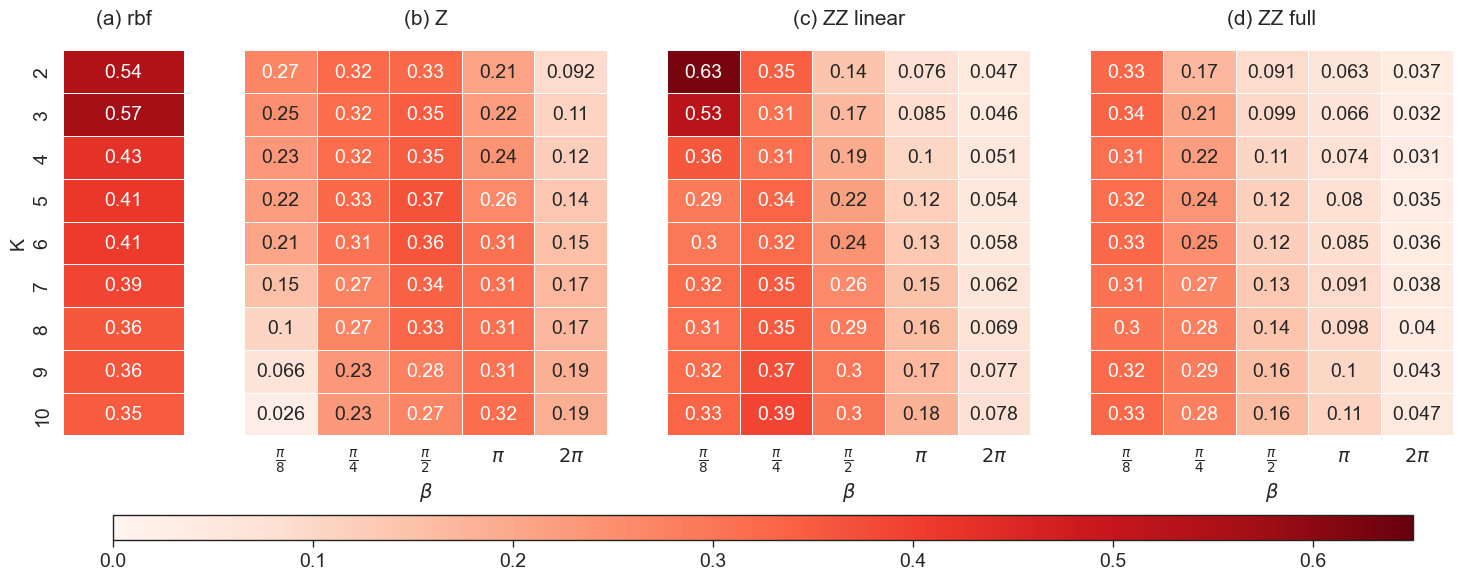

In [27]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5),gridspec_kw={'width_ratios': [1,3,3,3]},sharey=True)
#sns.set_context("paper", rc={"font.size":12,"axes.titlesize":13,"axes.labelsize":13,"axes.ticks.labelsize":18})
sns.set_palette("tab10")
cbar_flag=False
lettering=['(a) rbf','(b) Z','(c) ZZ linear','(d) ZZ full']

for i, ftmap in enumerate(['rbf','Z','ZZ_linear','ZZ_full']):
    print(ftmap)


    # Pivot the DataFrame
    new_df = df_2000[df_2000.ftmap==ftmap].pivot(index='K', columns=r'$\beta$', values='silhouette')
    if ftmap!='rbf':
        new_df=new_df.reindex(label_x,axis=1)
    
    
    # Plot the heatmap in the corresponding subplot
    ax = axs[i]
    sns.heatmap(new_df, annot=True, linewidth=.5, vmin=0, vmax=0.65, cmap=cmap_new, ax=ax,cbar=cbar_flag)
    if i!=0:
        ax.set_ylabel('')
        ax.set(xlabel=r'$\beta$')
    else:
        ax.set(xlabel='',xticklabels='')
    
    

    
    # Set the subplot title
    ax.set_title(lettering[i],loc='center',fontsize=15,fontweight='bold')
    

    
    # Set the x tick labels
   # ax.set_xticklabels(label_x, rotation=50, fontsize=10)
plt.subplots_adjust(wspace=0.2,right=0.82)
#Add ax under plot

cbar_ax=fig.add_axes([0.15,-0.1,0.65,0.05])

cbar1=cb.ColorbarBase(cbar_ax,cmap=cmap_new,orientation='horizontal',norm=plt.Normalize(vmin=0, vmax=0.65),location='bottom')


# Adjust the layout  


#save
#plt.tight_layout()

plt.savefig(dir_paper+'heatmap_SS_1980_alternative.pdf',dpi=600,format='pdf',bbox_inches='tight')
plt.show()

In [28]:
df_sim[r'$\beta$']=df_sim.Bandwidth.map({0.125:r'$\frac{\pi}{8}$',0.25:r'$\frac{\pi}{4}$',0.5:r'$\frac{\pi}{2}$',1:r'$\pi$',2:r'$2\pi$'})

In [29]:
df_real[r'$\beta$']=df_real.Bandwidth.map({0.125:r'$\frac{\pi}{8}$',0.25:r'$\frac{\pi}{4}$',0.5:r'$\frac{\pi}{2}$',1:r'$\pi$',2:r'$2\pi$'})

Z
ZZ_linear
ZZ_full


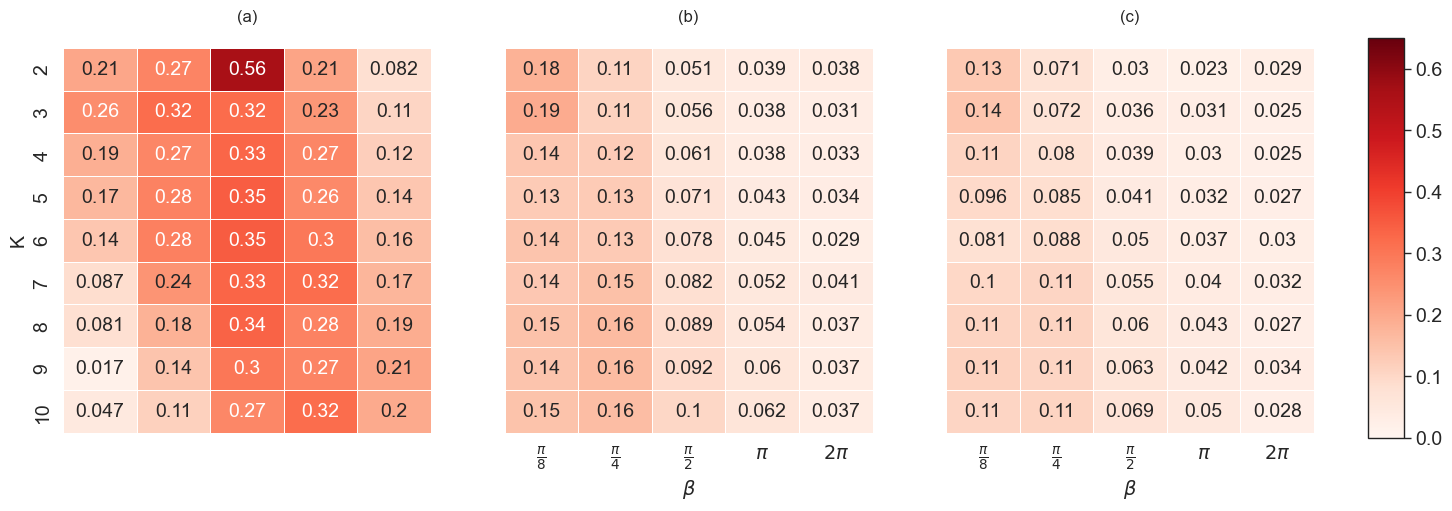

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5),gridspec_kw={'width_ratios': [3,3,3,]},sharey=True)
#sns.set_context("paper", rc={"font.size":12,"axes.titlesize":13,"axes.labelsize":13,"axes.ticks.labelsize":18})
sns.set_palette("tab10")
cbar_flag=False
lettering=['(a)','(b)','(c)','(d)']

for i, ftmap in enumerate(['Z','ZZ_linear','ZZ_full']):
    print(ftmap)


    # Pivot the DataFrame
    new_df = df_real[df_real.ftmap==ftmap].pivot(index='K', columns=r'$\beta$', values='silhouette')
    if ftmap!='rbf':
        new_df=new_df.reindex(label_x,axis=1)
    
    
    # Plot the heatmap in the corresponding subplot
    ax = axs[i]
    sns.heatmap(new_df, annot=True, linewidth=.5, vmin=0, vmax=0.65, cmap=cmap_new, ax=ax,cbar=cbar_flag)
    if i!=0:
        ax.set_ylabel('')
        ax.set(xlabel=r'$\beta$')
    else:
        ax.set(xlabel='',xticklabels='')
    
    

    
    # Set the subplot title
    ax.set_title(lettering[i],loc='center',fontsize=12,fontweight='bold')
    

    
    # Set the x tick labels
   # ax.set_xticklabels(label_x, rotation=50, fontsize=10)
plt.subplots_adjust(wspace=0.2,right=0.82)
#Add ax
cbar_ax=fig.add_axes([0.85,0.1,0.02,0.8])

cbar1=cb.ColorbarBase(cbar_ax,cmap=cmap_new,orientation='vertical',norm=plt.Normalize(vmin=0, vmax=0.65))


# Adjust the layout  


#save
#plt.savefig(dir_paper+'heatmap_SS_1980_center.pdf',dpi=600,format='pdf')
plt.show()

In [31]:
circuit_depth=[5,63,45]

In [32]:
df[r'$\beta$']=df['Bandwidth'].map({0.125:r'$\frac{\pi}{8}$',0.25:r'$\frac{\pi}{4}$',0.5:r'$\frac{\pi}{2}$',1:r'$\pi$',2:r'$2\pi$'})

In [33]:
df

Unnamed: 0      ftmap   K  Bandwidth             s  geom_distance  \
0             0        rbf   2      0.125  17881.043575       1.751525   
1             1        rbf   3      0.125  17881.043575       1.751525   
2             2        rbf   4      0.125  17881.043575       1.751525   
3             3        rbf   5      0.125  17881.043575       1.751525   
4             4        rbf   6      0.125  17881.043575       1.751525   
..          ...        ...  ..        ...           ...            ...   
355         175  ZZ_linear   6      2.000   1522.418182       4.282496   
356         176  ZZ_linear   7      2.000   1522.418182       4.282496   
357         177  ZZ_linear   8      2.000   1522.418182       4.282496   
358         178  ZZ_linear   9      2.000   1522.418182       4.282496   
359         179  ZZ_linear  10      2.000   1522.418182       4.282496   

     concentration  silhouette  Score_cluster        CHI        DI   v_intra  \
0         0.040536    0.769213       0.761888  44.248236  0.948850  0.019627   
1         0.040536    0.578659       0.669947  75.249441  0.026336  0.006730   
2         0.040536    0.381487       0.639101  66.995311  0.022874  0.005174   
3         0.040536    0.339353       0.644123  56.611376  0.015088  0.004944   
4         0.040536    0.392213       0.700089  59.503937  0.016159  0.003948   
..             ...         ...            ...        ...       ...       ...   
355       0.004610    0.028806       0.051116   4.995966  0.491525  0.010437   
356       0.004610    0.041034       0.073231   3.053682  0.503240  0.011448   
357       0.004610    0.037272       0.068450   4.032012  0.491525  0.011798   
358       0.004610    0.036757       0.073994   4.069062  0.491525  0.012861   
359       0.004610    0.036657       0.082713   2.863801  0.488484  0.013347   

      v_inter  N_samples       Type          $\beta$  
0    0.007880        100  Simulated  $\frac{\pi}{8}$  
1    0.050097        100  Simulated  $\frac{\pi}{8}$  
2    0.046837        100  Simulated  $\frac{\pi}{8}$  
3    0.044443        100  Simulated  $\frac{\pi}{8}$  
4    0.042539        100  Simulated  $\frac{\pi}{8}$  
..        ...        ...        ...              ...  
355  0.002982        100       Real           $2\pi$  
356  0.002899        100       Real           $2\pi$  
357  0.003066        100       Real           $2\pi$  
358  0.003124        100       Real           $2\pi$  
359  0.003057        100       Real           $2\pi$  

[360 rows x 16 columns]

In [34]:

df_delta=df_sim[['ftmap','K','Bandwidth','silhouette','DI']].merge(df_real[['ftmap','K','Bandwidth','silhouette','DI']],on=['ftmap','K','Bandwidth'],suffixes=('_sim','_real'))
df_delta['delta_s']=np.abs(df_delta['silhouette_sim']-df_delta['silhouette_real'])
df_delta['delta_DI']=np.abs(df_delta['DI_sim']-df_delta['DI_real'])

In [35]:
df_delta[r'$\beta$']=df_delta['Bandwidth'].map({0.125:r'$\frac{\pi}{8}$',0.25:r'$\frac{\pi}{4}$',0.5:r'$\frac{\pi}{2}$',1:r'$\pi$',2:r'$2\pi$'})

In [36]:
df_delta.head()

ftmap  K  Bandwidth  silhouette_sim    DI_sim  silhouette_real   DI_real  \
0   rbf  2      0.125        0.769213  0.948850         0.769213  0.948850   
1   rbf  3      0.125        0.578659  0.026336         0.578659  0.026336   
2   rbf  4      0.125        0.381487  0.022874         0.381487  0.022874   
3   rbf  5      0.125        0.339353  0.015088         0.339353  0.015088   
4   rbf  6      0.125        0.392213  0.016159         0.392213  0.016159   

   delta_s  delta_DI          $\beta$  
0      0.0       0.0  $\frac{\pi}{8}$  
1      0.0       0.0  $\frac{\pi}{8}$  
2      0.0       0.0  $\frac{\pi}{8}$  
3      0.0       0.0  $\frac{\pi}{8}$  
4      0.0       0.0  $\frac{\pi}{8}$

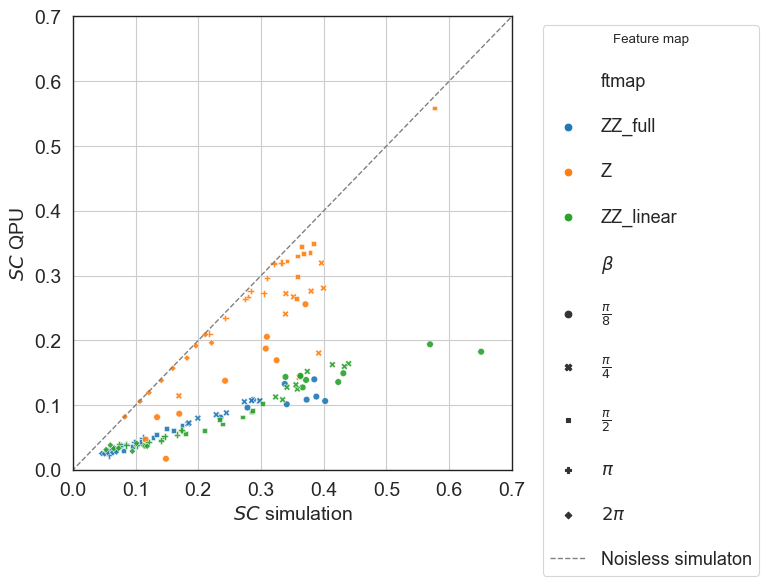

In [37]:

score_to_plot='silhouette'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_delta[df_delta['ftmap'] != 'rbf'], x='{}_sim'.format(score_to_plot), y='{}_real'.format(score_to_plot),
                 style=r'$\beta$',markers=True, palette='tab10',hue='ftmap',alpha=0.9)
    #Add ideal line
plt.plot([-0.1,1],[-0.1,1],color='grey',linestyle='--',label='Noisless simulaton')

    
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=13,title='Feature map')
#Axes labels
plt.ylabel(r'$SC$ QPU')
plt.xlabel(r'$SC$ simulation')   
    
# Set the y-axis limits
plt.ylim(0, 0.7)
plt.xlim(0, 0.7)
plt.tight_layout()
plt.savefig(dir_paper+'{}_coherence_realvssim_one.pdf'.format(score_to_plot), dpi=600,format='pdf')
plt.show()

## AMI 


In [38]:
df_clust_real=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_umap_100_hardware/Mumbai_CU/clustering_100_clusters.csv',index_col=0)
df_clust_sim=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_100_umap/clustering_100_clusters.csv',index_col=0)

In [39]:
df_clust_real.columns = df_clust_sim.columns.str.replace("_Z_full", "_Z")
df_clust_sim.columns = df_clust_real.columns.str.replace("_Z_full", "_Z")

Calculate NMI and Rand Index between the simulation results and its real counterpart

In [40]:
#calculate nmi, ami and ari between real and simulated comon columns
#save the results in a dictionary

nmi_ari_dict_list=[]
for col in df_clust_real.columns:
    
    clust=col.split('_')
  

    if clust[1]=='Z':
        ftmap=clust[1]

        
    elif clust[1]=='ZZ':
        ftmap=clust[1]+'_'+clust[2]
    else:
        ftmap='rbf'

    ari=adjusted_rand_score(df_clust_real[col],df_clust_sim[col])
    nmi=normalized_mutual_info_score(df_clust_real[col],df_clust_sim[col])
    ami=adjusted_mutual_info_score(df_clust_real[col],df_clust_sim[col])
    print('ARI for {} is {}'.format(col,ari))
    print('NMI for {} is {}'.format(col,nmi))
    print('AMI for {} is {}'.format(col,ami))


    nmi_ari_dict_list.append({'ftmap':ftmap,
                              'K':clust[-2],
                              'Bandwidth':clust[-1],
                              'ARI':ari,
                              'NMI':nmi,
                              'AMI':ami})


ARI for Cluster_rbf_2_0.125 is 1.0
NMI for Cluster_rbf_2_0.125 is 1.0
AMI for Cluster_rbf_2_0.125 is 1.0
ARI for Cluster_rbf_3_0.125 is 1.0
NMI for Cluster_rbf_3_0.125 is 1.0
AMI for Cluster_rbf_3_0.125 is 1.0
ARI for Cluster_rbf_4_0.125 is 1.0
NMI for Cluster_rbf_4_0.125 is 1.0
AMI for Cluster_rbf_4_0.125 is 1.0
ARI for Cluster_rbf_5_0.125 is 1.0
NMI for Cluster_rbf_5_0.125 is 1.0
AMI for Cluster_rbf_5_0.125 is 1.0
ARI for Cluster_rbf_6_0.125 is 1.0
NMI for Cluster_rbf_6_0.125 is 1.0
AMI for Cluster_rbf_6_0.125 is 1.0
ARI for Cluster_rbf_7_0.125 is 1.0
NMI for Cluster_rbf_7_0.125 is 1.0
AMI for Cluster_rbf_7_0.125 is 1.0
ARI for Cluster_rbf_8_0.125 is 1.0
NMI for Cluster_rbf_8_0.125 is 1.0
AMI for Cluster_rbf_8_0.125 is 1.0
ARI for Cluster_rbf_9_0.125 is 1.0
NMI for Cluster_rbf_9_0.125 is 1.0
AMI for Cluster_rbf_9_0.125 is 1.0
ARI for Cluster_rbf_10_0.125 is 1.0
NMI for Cluster_rbf_10_0.125 is 1.0
AMI for Cluster_rbf_10_0.125 is 1.0
ARI for Cluster_rbf_2_0.25 is 1.0
NMI for Cluster_rb

In [41]:
#List of dictionaries to dataframe
df_nmi_ari=pd.DataFrame(nmi_ari_dict_list)

In [42]:
#Select best case according to AMI
df_nmi_ari[(df_nmi_ari.ftmap !='rbf') & (df_nmi_ari.ARI==1)].sort_values(by='AMI',ascending=False)

ftmap  K Bandwidth  ARI  NMI  AMI
100     Z  3      0.25  1.0  1.0  1.0
102     Z  5      0.25  1.0  1.0  1.0
108     Z  2       0.5  1.0  1.0  1.0
109     Z  3       0.5  1.0  1.0  1.0
117     Z  2         1  1.0  1.0  1.0
118     Z  3         1  1.0  1.0  1.0
120     Z  5         1  1.0  1.0  1.0
122     Z  7         1  1.0  1.0  1.0
126     Z  2         2  1.0  1.0  1.0
128     Z  4         2  1.0  1.0  1.0

In [43]:
#Lets check which has the best silhouette score
best_ami_idx=df_nmi_ari[(df_nmi_ari.ftmap !='rbf') & (df_nmi_ari.ARI==1)].sort_values(by='AMI',ascending=False).index

In [44]:
df_nmi_ari[r'$\beta$']=df_nmi_ari['Bandwidth'].map({'0.125':r'$\frac{\pi}{8}$','0.25':r'$\frac{\pi}{4}$','0.5':r'$\frac{\pi}{2}$','1':r'$\pi$','2':r'$2\pi$'})

In [45]:
df_nmi_ari

ftmap   K Bandwidth       ARI       NMI       AMI          $\beta$
0          rbf   2     0.125  1.000000  1.000000  1.000000  $\frac{\pi}{8}$
1          rbf   3     0.125  1.000000  1.000000  1.000000  $\frac{\pi}{8}$
2          rbf   4     0.125  1.000000  1.000000  1.000000  $\frac{\pi}{8}$
3          rbf   5     0.125  1.000000  1.000000  1.000000  $\frac{\pi}{8}$
4          rbf   6     0.125  1.000000  1.000000  1.000000  $\frac{\pi}{8}$
..         ...  ..       ...       ...       ...       ...              ...
175  ZZ_linear   6         2  0.113810  0.257133  0.188900           $2\pi$
176  ZZ_linear   7         2  0.181277  0.332615  0.249163           $2\pi$
177  ZZ_linear   8         2  0.111184  0.296075  0.177212           $2\pi$
178  ZZ_linear   9         2  0.124463  0.336909  0.192174           $2\pi$
179  ZZ_linear  10         2  0.098061  0.303312  0.117225           $2\pi$

[180 rows x 7 columns]

Z
0
ZZ_linear
1
ZZ_full


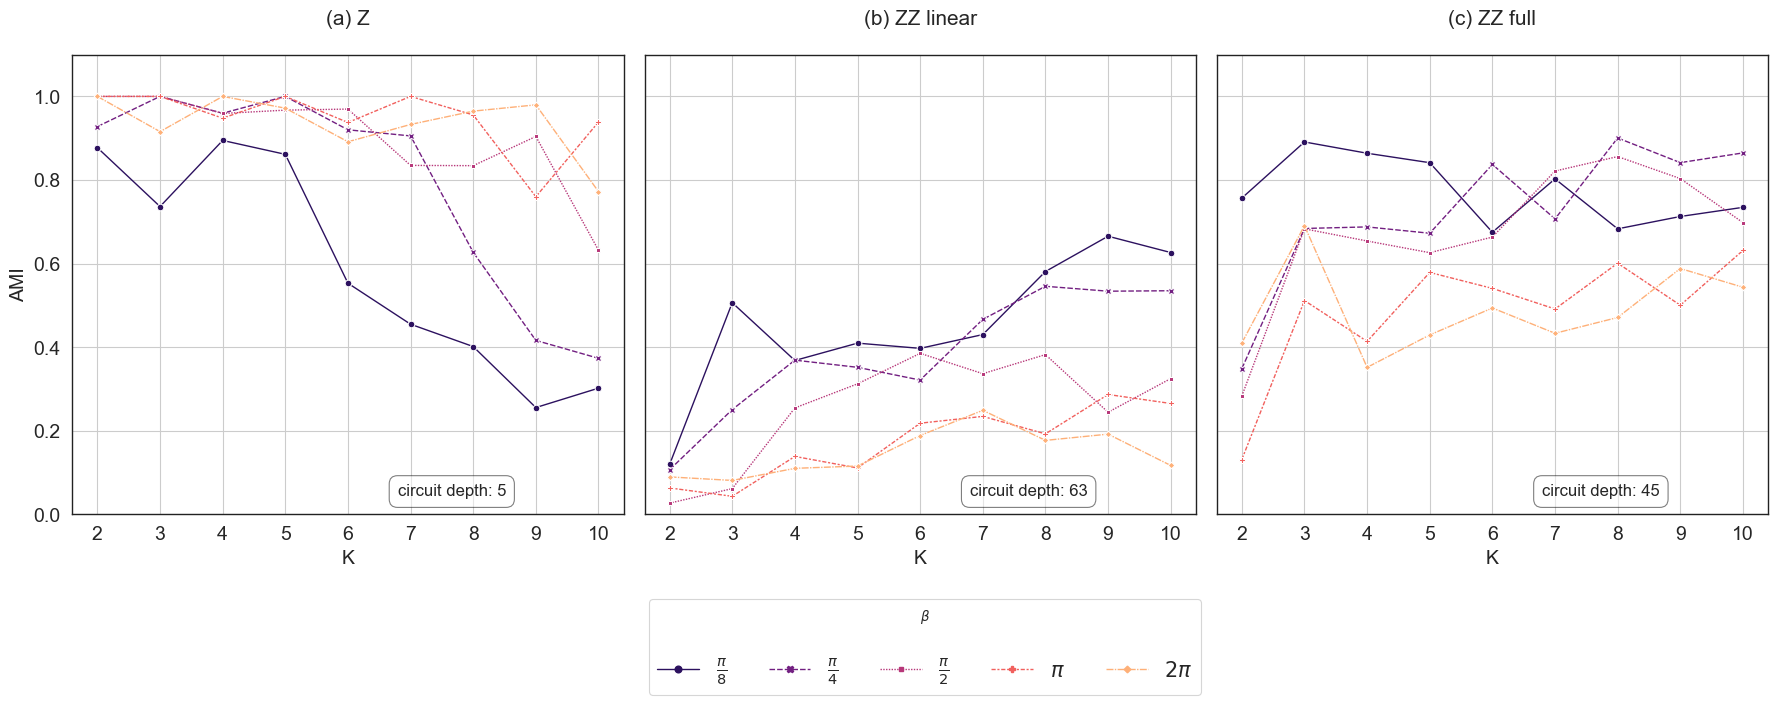

In [46]:
    
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(18,6),gridspec_kw={'width_ratios': [2.5,2.5,2.5]},sharey=True)
score_to_plot='AMI'
# Iterate over each feature map
lettering=['(a) Z','(b) ZZ linear','(c) ZZ full']
for i, ft_map in enumerate(['Z', 'ZZ_linear', 'ZZ_full']):
    # Filter the dataframe for the current feature map
    ft_map_df = df[df['ftmap'] == ft_map]
    
    # Plot the data in the corresponding subplot
    ax = axs[i]
    print(ft_map)
    
    sns.lineplot(data=df_nmi_ari[df_nmi_ari['ftmap'].isin([ft_map])], x='K', y=score_to_plot, hue=r'$\beta$',style=r'$\beta$',markers=True, palette='magma',ax=ax)
    
    
    
    # Set the plot title
    ax.set_title(lettering[i],loc='center',fontsize=15,fontweight='bold')
    
    # Set the y-axis limits
    ax.set_ylim(0, 1.1)
    #ax.set_xlim(2, 9)
    
    # Add text tag to the plot
    ax.text(0.59, 0.04, 'circuit depth: {}'.format(circuit_depth[i]),
             transform=ax.transAxes,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5',alpha=0.5),fontsize=12)
    # Disable legend for all but the first subplot
    if i!= 2:
        print(i)
        ax.legend_.remove()

# Move the legend outside the plot
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Get handles and labels for legend from the last axis
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()

# Add a single legend outside the subplots
fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.52, 0),
          fancybox=True, shadow=False, ncol=6,title=r'$\beta$',fontsize=15)
#fig.legend(handles, labels, loc='upper right', title=r'$\beta$',fontsize=13,bbox_to_anchor=(1.07, 0.9),)
# Adjust the plot layout
plt.tight_layout()
plt.savefig('{}_coherence.pdf'.format(score_to_plot), dpi=600,format='pdf',bbox_inches='tight')

# Show the plot
plt.show()


In [47]:
df_nmi_ari['K']=df_nmi_ari['K'].astype(int)
df_nmi_ari['Bandwidth']=df_nmi_ari['Bandwidth'].astype(float)

In [48]:
df_nmi_ari_2=df_nmi_ari.merge(df_sim[['ftmap','K','Bandwidth','silhouette']],on=['ftmap','K','Bandwidth'],suffixes=('_ARI','_SC'))

In [49]:
df_nmi_ari_2.head()

ftmap  K  Bandwidth  ARI  NMI  AMI          $\beta$  silhouette
0   rbf  2      0.125  1.0  1.0  1.0  $\frac{\pi}{8}$    0.769213
1   rbf  3      0.125  1.0  1.0  1.0  $\frac{\pi}{8}$    0.578659
2   rbf  4      0.125  1.0  1.0  1.0  $\frac{\pi}{8}$    0.381487
3   rbf  5      0.125  1.0  1.0  1.0  $\frac{\pi}{8}$    0.339353
4   rbf  6      0.125  1.0  1.0  1.0  $\frac{\pi}{8}$    0.392213

Z
0
ZZ_linear
1
ZZ_full


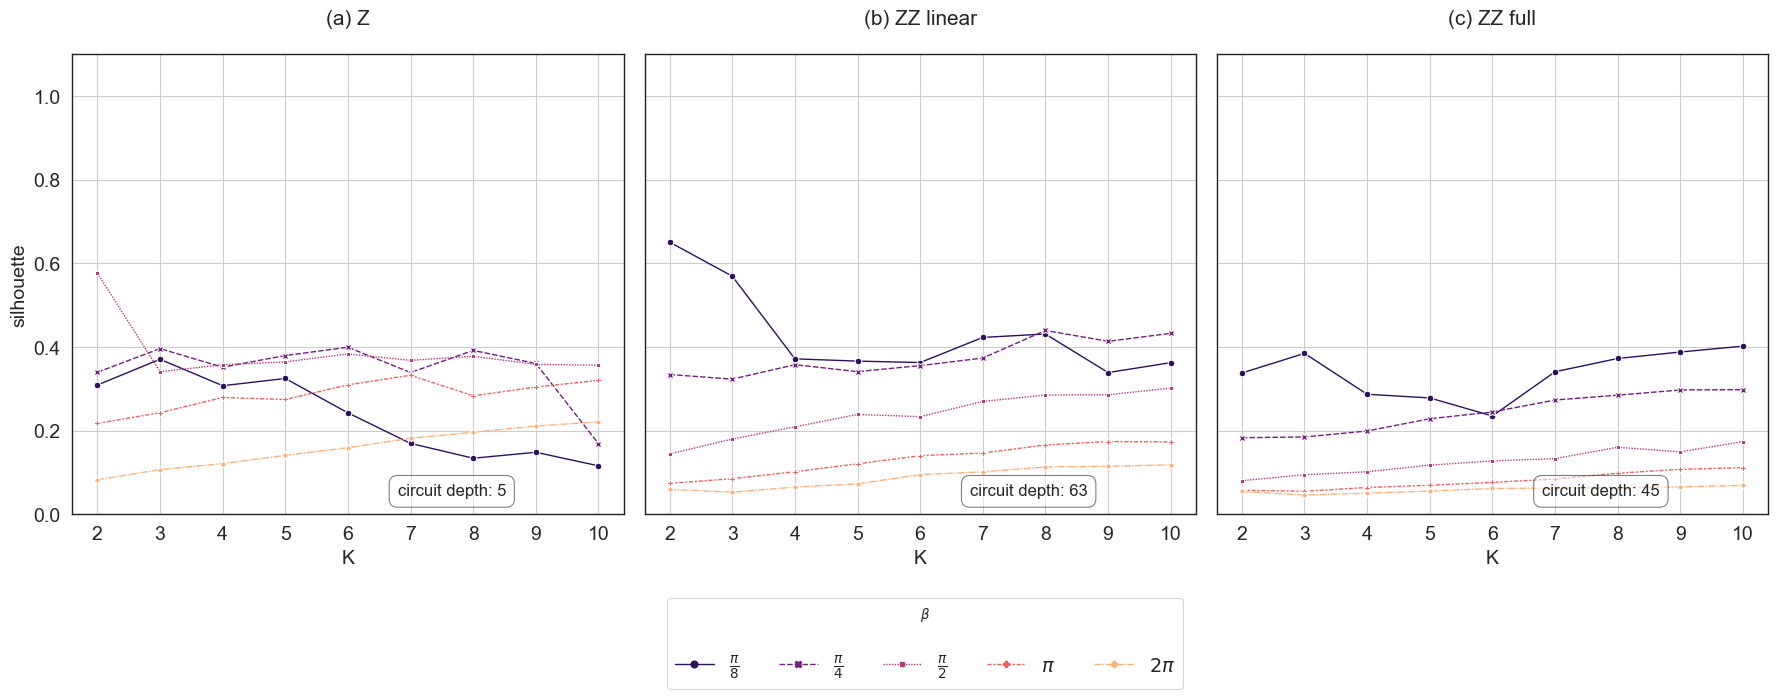

In [50]:
    
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(18,6),gridspec_kw={'width_ratios': [2.5,2.5,2.5]},sharey=True)
score_to_plot='silhouette'
# Iterate over each feature map
lettering=['(a) Z','(b) ZZ linear','(c) ZZ full']
for i, ft_map in enumerate(['Z', 'ZZ_linear', 'ZZ_full']):
    # Filter the dataframe for the current feature map
    ft_map_df = df[df['ftmap'] == ft_map]
    
    # Plot the data in the corresponding subplot
    ax = axs[i]
    print(ft_map)
    
    sns.lineplot(data=df_nmi_ari_2[df_nmi_ari_2['ftmap'].isin([ft_map])], x='K', y=score_to_plot, hue=r'$\beta$',style=r'$\beta$',markers=True, palette='magma',ax=ax)
    
    
    
    # Set the plot title
    ax.set_title(lettering[i],loc='center',fontsize=15,fontweight='bold')
    
    # Set the y-axis limits
    ax.set_ylim(0, 1.1)
    #ax.set_xlim(2, 9)
    
    # Add text tag to the plot
    ax.text(0.59, 0.04, 'circuit depth: {}'.format(circuit_depth[i]),
             transform=ax.transAxes,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5',alpha=0.5),fontsize=12)
    # Disable legend for all but the first subplot
    if i!= 2:
        print(i)
        ax.legend_.remove()

# Move the legend outside the plot
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Get handles and labels for legend from the last axis
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()

# Add a single legend outside the subplots
fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.52, 0),
          fancybox=True, shadow=False, ncol=6,title=r'$\beta$',fontsize=14)
#fig.legend(handles, labels, loc='upper right', title=r'$\beta$',fontsize=13,bbox_to_anchor=(1.07, 0.9),)
# Adjust the plot layout
plt.tight_layout()
#plt.savefig('{}_coherence.pdf'.format(score_to_plot), dpi=600,format='pdf',bbox_inches='tight')

# Show the plot
plt.show()


Merge figures with mosaic:

In [51]:
def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

Z
ZZ_linear
ZZ_full


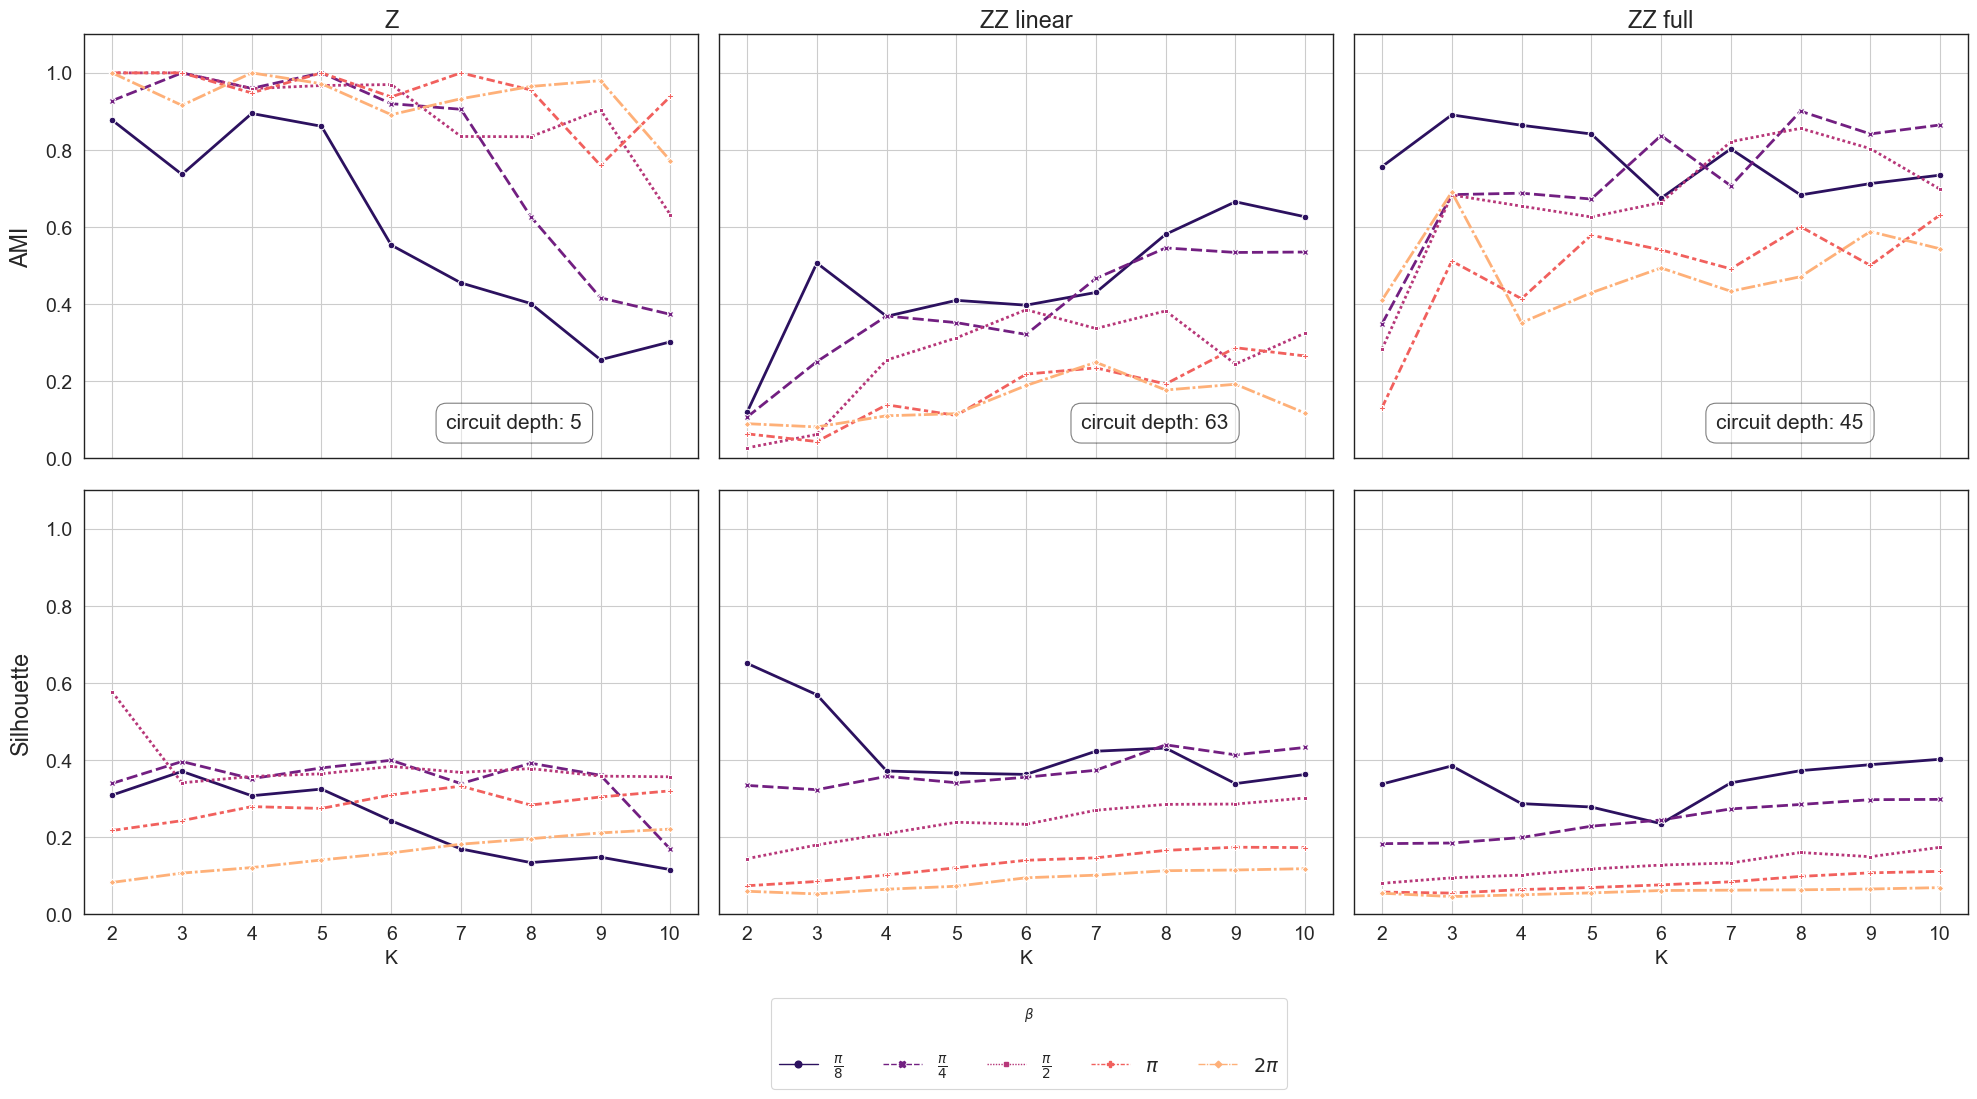

In [53]:
mosaic = [
    ["A0", "A1", "A2"],
    ["B0", "B1", "B2"],
]
row_headers = ["AMI", "Silhouette"]
col_headers = ["Z", "ZZ linear", "ZZ full"]

subplots_kwargs = dict(sharex=True, sharey=True, figsize=(20, 10))
fig, axes = plt.subplot_mosaic(mosaic, **subplots_kwargs)

for i, ft_map in enumerate(['Z', 'ZZ_linear', 'ZZ_full']):
    # Filter the dataframe for the current feature map
    ft_map_df = df[df['ftmap'] == ft_map]
    
    # Plot the data in the corresponding subplot
    idx='A'+str(i)
    ax = axes[idx]
    print(ft_map)

    
    sns.lineplot(data=df_nmi_ari_2[df_nmi_ari_2['ftmap'].isin([ft_map])], x='K', y='AMI', hue=r'$\beta$',style=r'$\beta$',markers=True, palette='magma',linewidth = 2,ax=ax)
    plt.ylabel('')
    # Set the y-axis limits
    ax.set_ylim(0, 1.1)
    #ax.set_xlim(2, 9)
    
    # Add text tag to the plot
    ax.text(0.59, 0.07, 'circuit depth: {}'.format(circuit_depth[i]),
             transform=ax.transAxes,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5',alpha=0.5),fontsize=15)
    # Disable legend for all but the first subplot
 
    ax.legend_.remove()
    #Then plot silhouette
    idx='B'+str(i)
    ax = axes[idx]
    sns.lineplot(data=df_nmi_ari_2[df_nmi_ari_2['ftmap'].isin([ft_map])], x='K', y='silhouette', hue=r'$\beta$',style=r'$\beta$',markers=True, palette='magma',linewidth = 2,ax=ax,legend=False) 
    
    
   
    
axes['A0'].set_ylabel('')
axes['B0'].set_ylabel('')


font_kwargs = dict(fontweight="bold", fontsize="large")
#ig.add_headers( col_headers=col_headers, row_headers=row_headers, **font_kwargs)
add_headers(fig, col_headers=col_headers, row_headers=row_headers, **font_kwargs)
# Get handles and labels for legend from the last axis
handles, labels = axes['A0'].get_legend_handles_labels()


# Add a single legend outside the subplots
fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.52, 0),
          fancybox=True, shadow=False, ncol=6,title=r'$\beta$',fontsize=14)
#fig.legend(handles, labels, loc='upper right', title=r'$\beta$',fontsize=13,bbox_to_anchor=(1.07, 0.9),)
# Adjust the plot layout
plt.tight_layout()
plt.savefig('{}_coherence_and_SC.pdf'.format('AMI'), dpi=600,format='pdf',bbox_inches='tight')

# Show the plot
plt.show()

<Axes: xlabel='silhouette', ylabel='AMI'>

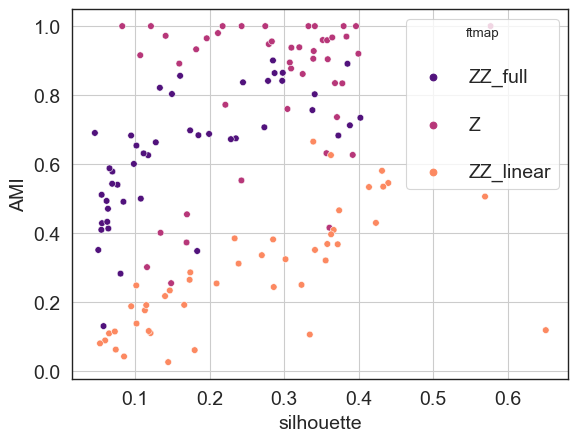

In [52]:
sns.scatterplot(data=df_nmi_ari_2[df_nmi_ari_2['ftmap']!='rbf'], x='silhouette',hue='ftmap', y=score_to_plot,markers=True, palette='magma')
    

<Axes: xlabel='AMI', ylabel='Count'>

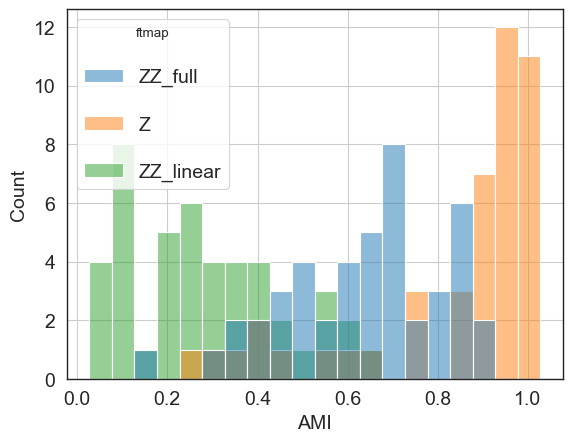

In [53]:
sns.histplot(data=df_nmi_ari[df_nmi_ari['ftmap'] != 'rbf'],x='AMI',hue='ftmap',
             fill=True,binwidth=0.05,palette='tab10',
             )

<Axes: xlabel='AMI', ylabel='ftmap'>

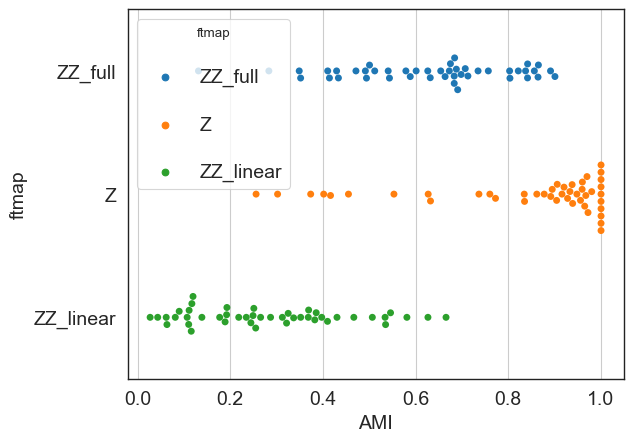

In [54]:
sns.swarmplot(df_nmi_ari[df_nmi_ari['ftmap'] != 'rbf'],x='AMI',hue='ftmap',y='ftmap')

<Axes: xlabel='AMI', ylabel='ftmap'>

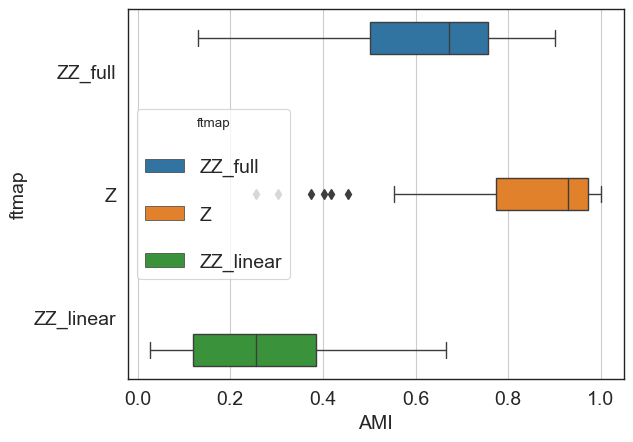

In [56]:
sns.boxplot(data=df_nmi_ari[df_nmi_ari['ftmap'] != 'rbf'],y='ftmap',hue='ftmap',x='AMI',palette='tab10')

In [57]:
import plotly.graph_objects as go
# Read data from a csv
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')
z = z_data.values
sh_0, sh_1 = z.shape
x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [63]:
prova=df_nmi_ari[df_nmi_ari['ftmap'] == 'ZZ_full']
fig = go.Figure(data=[go.Surface(z=prova.AMI, x=prova.Bandwidth.astype(float), y=prova.K.astype(float))])
fig.update_layout(title='Mt Bruno Elevation', autosize=True
                  )
fig.show()

In [51]:

# Convert the columns to the same data type before merging
df_delta[['Bandwidth']] = df_delta[['Bandwidth']].astype(float)
df_nmi_ari[['Bandwidth']] = df_nmi_ari[['Bandwidth']].astype(float)
df_delta[['K']] = df_delta[['K']].astype(int)
df_nmi_ari[['K']] = df_nmi_ari[['K']].astype(int)

df_merged = df_delta.merge(df_nmi_ari, on=['ftmap','Bandwidth','K',r'$\beta$'])


# Sankey and Survival


### Load and prepare data

In [ ]:
#Load original patient index from data and metabric data(metadata)
#Load clustering data
print('#### CASE 1000 samples simulated ####')
df_clust=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_1000_umap/clustering_1000_clusters.csv',index_col=0)
df_clust.columns = df_clust.columns.str.replace("_Z_full", "_Z")
df_clust.replace('Z_full','Z',inplace=True)
data_input = pd.read_csv("Input_data/UMAP_METABRIC_4cmp_IC10_full.csv", sep = ",",index_col=0)
patient_index=data_input.sample(n=1000,axis=0,random_state=42).index
#set index to df_clust to patient index
df_clust.index=patient_index

#Load metadata
metabric = pd.read_csv('/CTGlab/data/brca_metabric/data_clinical_patient.txt', sep='\t', skiprows=[0,1,2,3])
#Remove patients with missing OS_STATUS and merge with data
metabricSubset = metabric.loc[~metabric['OS_STATUS'].isna()]
quantumDf = pd.merge(metabricSubset, df_clust, how='left', right_on=[df_clust.index], left_on=['PATIENT_ID']).dropna(subset=df_clust.columns)
quantumDf['OS_STATUS_censored'] = quantumDf['VITAL_STATUS'].apply(lambda x: 1 if x == "Died of Disease" else 0) 
quantumDf['OS_STATUS'] = quantumDf['OS_STATUS'].apply(lambda x: int(x.split(':')[0]))

#### CASE 1000 samples simulated ####


In [ ]:
print('#### CASE 100 samples real ####')
patient_index_100=data_input.sample(n=100,axis=0,random_state=42).index
df_clust_real.index=patient_index_100
quantumDf_real_100 = pd.merge(metabricSubset, df_clust_real, how='left', right_on=[df_clust_real.index], left_on=['PATIENT_ID']).dropna(subset=df_clust_real.columns)
quantumDf_real_100['OS_STATUS_censored'] = quantumDf_real_100['VITAL_STATUS'].apply(lambda x: 1 if x == "Died of Disease" else 0)
quantumDf_real_100['OS_STATUS'] = quantumDf_real_100['OS_STATUS'].apply(lambda x: int(x.split(':')[0]))

#### CASE 100 samples real ####


In [ ]:
print('#### CASE 100 samples sim ####')
df_clust_sim.index=patient_index_100
quantumDf_sim_100 = pd.merge(metabricSubset, df_clust_sim, how='left', right_on=[df_clust_sim.index], left_on=['PATIENT_ID']).dropna(subset=df_clust_sim.columns)
quantumDf_sim_100['OS_STATUS_censored'] = quantumDf_sim_100['VITAL_STATUS'].apply(lambda x: 1 if x == "Died of Disease" else 0)
quantumDf_sim_100['OS_STATUS'] = quantumDf_sim_100['OS_STATUS'].apply(lambda x: int(x.split(':')[0]))


#### CASE 100 samples sim ####


## Check Survival



In [ ]:
def plot_KM_curves(survDf: pd.DataFrame, durationVar: str, eventVar: str, indVar: str, ax=None, groups=None, **kwargs):
    """
    Plot KM curve with respect to an independent variable, including logrank test.

    Parameters:
    - survDf (pd.DataFrame): dataframe
    - durationVar (str): Column name with survival time
    - eventVar (str): Column name denoting the event. Must be encoded as boolean or int (0,1)
    - indVar (str): Column name with the independent variable. If it contains more than two different values, the groups 
        to be tested with the log-rank must be provided with the groups argument
    - ax (plt.Axes): matplotlib axes
    - groups (Iterable): Iterable containing values to be tested for logrank
    - **kwargs: arguments for the lifelines.KaplanMeierFitter function.

    Returns:

    plt.Axes
    """
    levels = np.sort(survDf[indVar].dropna().unique())
    if len(levels) == 2:
            pval = lifelines.statistics.logrank_test(
            durations_A=survDf[survDf[indVar] == levels[0]][durationVar],
            durations_B=survDf[survDf[indVar] == levels[1]][durationVar],
            events_observed_A=survDf[survDf[indVar] == levels[0]][eventVar],
            events_observed_B=survDf[survDf[indVar] == levels[1]][eventVar]
            ).p_value
    else:
        try:
            iter(groups)
            pval = lifelines.statistics.logrank_test(
                durations_A=survDf[survDf[indVar] == groups[0]][durationVar],
                durations_B=survDf[survDf[indVar] == groups[1]][durationVar],
                events_observed_A=survDf[survDf[indVar] == groups[0]][eventVar],
                events_observed_B=survDf[survDf[indVar] == groups[1]][eventVar]
                ).p_value
        except TypeError:
            print('Groups require an iterable containing two variables to compare between')
            return None
    kmPlots = [None for _ in levels]
    # calc the p-val
    at = AnchoredText('$p$: {}'.format(float(np.round(pval, 7))),prop=dict(fontproperties=fm.FontProperties(fname=fontPath, size=12)), frameon=True, loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    # ax.set_title(f'KM curve for covariate "{var}"')
    ax.add_artist(at)
    ax.set_facecolor('none')
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    for idx,level in enumerate(levels):
        kmPlots[idx] = lifelines.KaplanMeierFitter()
        events = (survDf[indVar] == level)
        kmPlots[idx].fit(
            durations=survDf[durationVar][events],
            event_observed=survDf[eventVar][events],
            label=level)
        kmPlots[idx].plot(ax=ax, **kwargs, lw=2.5, color=sns.color_palette('colorblind')[idx])
    lifelines.plotting.add_at_risk_counts(*kmPlots, ax=ax, fontproperties=fm.FontProperties(fname=fontPath, size=10))


    return ax

In [ ]:
quantumDf['VITAL_STATUS'].value_counts()


VITAL_STATUS
Living                  435
Died of Disease         313
Died of Other Causes    251
Name: count, dtype: int64

In [ ]:
quantumDf['OS_MONTHS'].describe()

count    1000.000000
mean      128.472167
std        75.786077
min         0.000000
25%        64.541667
50%       122.733333
75%       186.558333
max       355.200000
Name: OS_MONTHS, dtype: float64

Text(0, 0.5, 'Overall survival probability')

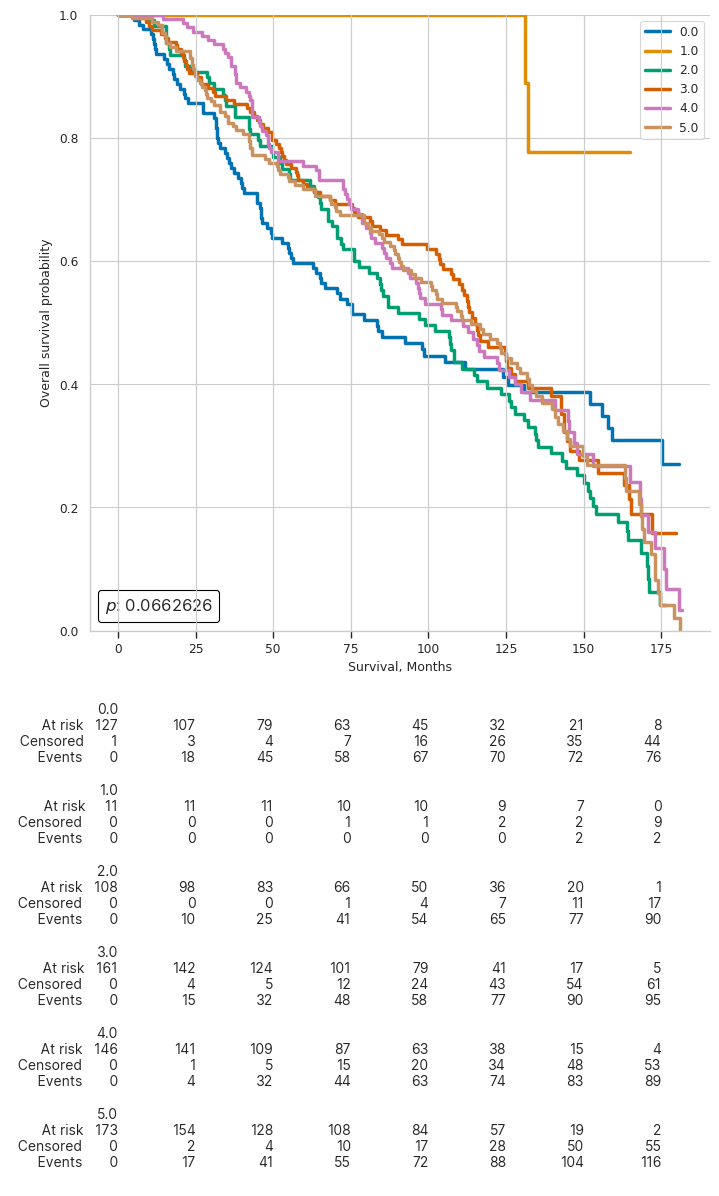

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot_KM_curves(
    quantumDf.loc[quantumDf['OS_MONTHS'] < 182], durationVar='OS_MONTHS',eventVar='OS_STATUS', indVar='Cluster_rbf_6_1', groups=range(0,6), ax=ax, ci_show=False)
ax.set_xlabel('Survival, Months')
ax.set_ylabel('Overall survival probability')
#ax.legend( loc="best")
#ax.set_title('ZZ_linear_039 clustering \n 8 clusters')
#fig.tight_layout()

## Sankey

### Real 100 samples

In [ ]:
cluster_col=[]
for i in quantumDf_real_100.columns:
    if 'Cluster' in i:
        cluster_col.append(i)

In [ ]:
quantumDf_s=quantumDf_real_100.copy()
for column in quantumDf_s.loc[:, ['INTCLUST','CLAUDIN_SUBTYPE']+cluster_col].columns:
    quantumDf_s[column] = quantumDf_s[column].apply(lambda x: f"{column}_{x}")

In [ ]:
def plotSankey(df: pd.DataFrame, cols: list, names=None,linkVar=None, valueToHighlight=None):
    """
    Plot a Sankey diagram based on the given dataframe and columns.

    Parameters:
    - df (pd.DataFrame): The dataframe containing the data.
    - cols (list): A list of column names to use for plotting.
    - linkVar (str): The name of the column to use as a link variable (optional).
    - valueToHighlight: The value in the link variable to highlight (optional).

    Returns:
    - fig: The generated plotly figure object.
    """
    colsToPlot = []
    for col in cols:
       colsToPlot.append(list(set(x for x in df[col])))

    mask = {}
    toenumerate = []
    for i in range(len(colsToPlot)):
       toenumerate = toenumerate + colsToPlot[i]
    for k,v in enumerate(toenumerate):
        mask[v] = k

    combinations = []
    for i in range(0, len(colsToPlot)-1):
       combinations = combinations + list(itertools.product(colsToPlot[i], colsToPlot[i+1]))
       

    sources = []
    targets = []
    values = []
    colors = []
    if linkVar != None:
      linkVarValues = df[linkVar].unique()
    for combination in combinations:
        source = mask[combination[0]]
        target = mask[combination[1]]
        column1 = '_'.join(combination[0].split('_')[:-1])
        column2 = '_'.join(combination[1].split('_')[:-1])
        
        if linkVar != None:
          for idx,val in enumerate(linkVarValues):
              flow = df.loc[(df[column1] == combination[0])&(df[column2] == combination[1])&(df[linkVar] == val)].shape[0]
              color = "lightgrey" if val != valueToHighlight else "orange"
              colors.append(color)
              sources.append(source) 
              targets.append(target)
              values.append(flow)
        else:
          flow = df.loc[(df[column1] == combination[0])&(df[column2] == combination[1])].shape[0]
          colors.append('lightgrey')
          sources.append(source) 
          targets.append(target)
          values.append(flow)
    
         
    fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = [f"{x.split('_')[-1]}" for x in toenumerate ]
    ),
    link = dict(
      source = sources, 
      target = targets,
      value = values,
      color = colors,
      label=[f"{x.split('_')[-1]}" for x in toenumerate ]
  ))])
    if names == None:
       names=cols
    for x_coordinate, column_name in enumerate(names):
        fig.add_annotation(
                x=x_coordinate,
                y=1.05,
                xref="x",
                yref="paper",
                text=column_name,
                showarrow=False,
                font=dict(
                    size=16,
                    color="black"
                    ),
                align="center",
                )
    fig.update_layout(
        title='Sample Assignments in Clustering Methods' if valueToHighlight==None else f"Sample Assignments in Clustering Methods\nHighlighted {valueToHighlight}",
        plot_bgcolor='white',
        paper_bgcolor='white',
        font_size=14,
        hovermode='x',
        autosize=False,
        width=1000, height=600,
        xaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        },
        yaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        }

    ) 
    fig.show()
    return fig

In [ ]:
quantumDf_s.CELLULARITY.value_counts()

CELLULARITY
High        51
Moderate    36
Low          9
Name: count, dtype: int64

To plot:
- first get the clusterings with the best coherence
- checek wich ones have the best silhouette and DI
- plot for confrontation


In [ ]:
#The ones with best silhouette
df_real.iloc[best_ami_idx].sort_values(by='silhouette',ascending=False)

Unnamed: 0 ftmap  K  Bandwidth             s  geom_distance  \
108         108     Z  2       0.50   6057.476628       2.091055   
109         109     Z  3       0.50   6057.476628       2.091055   
122         122     Z  7       1.00   4097.149781       3.207312   
100         100     Z  3       0.25  10403.194977       3.860099   
102         102     Z  5       0.25  10403.194977       3.860099   
120         120     Z  5       1.00   4097.149781       3.207312   
118         118     Z  3       1.00   4097.149781       3.207312   
117         117     Z  2       1.00   4097.149781       3.207312   
128         128     Z  4       2.00   6454.449698      10.512267   
126         126     Z  2       2.00   6454.449698      10.512267   

     concentration  silhouette  Score_cluster        CHI        DI   v_intra  \
108       0.066699    0.558708       0.546341  44.248236  0.878541  0.047888   
109       0.066699    0.322350       0.390373  47.500560  0.082701  0.030636   
122       0.053731    0.319908       0.396945  46.765743  0.135121  0.047943   
100       0.019106    0.319376       0.446294  32.530205  0.134315  0.006838   
102       0.019106    0.276013       0.477067  57.298958  0.101108  0.004788   
120       0.053731    0.263627       0.285558  42.044629  0.064890  0.062896   
118       0.053731    0.234614       0.188932  51.586242  0.154200  0.054458   
117       0.053731    0.210122       0.188603  44.248236  0.825989  0.050707   
128       0.023323    0.119377       0.149922   5.631460  0.264826  0.046313   
126       0.023323    0.081838       0.082667   0.604951  0.143146  0.033291   

      v_inter  N_samples  Type  
108  0.000839        100  Real  
109  0.065569        100  Real  
122  0.022372        100  Real  
100  0.042391        100  Real  
102  0.032672        100  Real  
120  0.024372        100  Real  
118  0.009508        100  Real  
117  0.000704        100  Real  
128  0.007921        100  Real  
126  0.008383        100  Real

In [ ]:
#plot best 3
cols_name_S=[]
cols_name_S_sel=[]
cols_to_plot=[]
cols_to_plot_full=[]
for i in df_real.iloc[best_ami_idx].sort_values(by='silhouette',ascending=False).itertuples():
    name='Cluster_'+i.ftmap+'_'+str((i.K))+'_'+f'{i.Bandwidth:g}'
    name_col='b:{},S:{:.2f}, DI:{:.2f}'.format(i.Bandwidth,i.silhouette,i.DI)
    cols_to_plot_full.append(name)
    cols_name_S.append(name_col)

    if i.K>3:
        cols_to_plot.append(name)
        cols_name_S_sel.append(name_col)
        
    
        

In [ ]:
cols_to_plot

['Cluster_Z_7_1', 'Cluster_Z_5_0.25', 'Cluster_Z_5_1', 'Cluster_Z_4_2']

Plot also cases with few clusters

In [ ]:
fig = plotSankey(quantumDf_s, cols=cols_to_plot_full,names=cols_name_S, valueToHighlight=['High'], linkVar='CELLULARITY')

We can see from the plot above that plots with k>3 contains subclusters so they can be discharged for further considerations even though they have higher silhouette scores(s) or DI scores. We then plot only those clustering wiyh k>3:

In [ ]:
fig = plotSankey(quantumDf_s, cols=cols_to_plot,names=cols_name_S_sel, valueToHighlight=['High'], linkVar='CELLULARITY')

Lets look at the DI following the same considerations

In [ ]:
#The ones with best DI
df_real.iloc[best_ami_idx].sort_values(by='DI',ascending=False)

Unnamed: 0 ftmap  K  Bandwidth             s  geom_distance  \
108         108     Z  2       0.50   6057.476628       2.091055   
117         117     Z  2       1.00   4097.149781       3.207312   
128         128     Z  4       2.00   6454.449698      10.512267   
118         118     Z  3       1.00   4097.149781       3.207312   
126         126     Z  2       2.00   6454.449698      10.512267   
122         122     Z  7       1.00   4097.149781       3.207312   
100         100     Z  3       0.25  10403.194977       3.860099   
102         102     Z  5       0.25  10403.194977       3.860099   
109         109     Z  3       0.50   6057.476628       2.091055   
120         120     Z  5       1.00   4097.149781       3.207312   

     concentration  silhouette  Score_cluster        CHI        DI   v_intra  \
108       0.066699    0.558708       0.546341  44.248236  0.878541  0.047888   
117       0.053731    0.210122       0.188603  44.248236  0.825989  0.050707   
128       0.023323    0.119377       0.149922   5.631460  0.264826  0.046313   
118       0.053731    0.234614       0.188932  51.586242  0.154200  0.054458   
126       0.023323    0.081838       0.082667   0.604951  0.143146  0.033291   
122       0.053731    0.319908       0.396945  46.765743  0.135121  0.047943   
100       0.019106    0.319376       0.446294  32.530205  0.134315  0.006838   
102       0.019106    0.276013       0.477067  57.298958  0.101108  0.004788   
109       0.066699    0.322350       0.390373  47.500560  0.082701  0.030636   
120       0.053731    0.263627       0.285558  42.044629  0.064890  0.062896   

      v_inter  N_samples  Type  
108  0.000839        100  Real  
117  0.000704        100  Real  
128  0.007921        100  Real  
118  0.009508        100  Real  
126  0.008383        100  Real  
122  0.022372        100  Real  
100  0.042391        100  Real  
102  0.032672        100  Real  
109  0.065569        100  Real  
120  0.024372        100  Real

In [ ]:
cols_to_plot_DI=[]
cols_name_DI=[]
for i in df_real.iloc[best_ami_idx].sort_values(by='DI',ascending=False).itertuples():
    if i.K>3:
        name='Cluster_'+i.ftmap+'_'+str((i.K))+'_'+f'{i.Bandwidth:g}'
        name_col='b:{},S:{:.2f}, DI:{:.2f}'.format(i.Bandwidth,i.silhouette,i.DI)
        cols_name_DI.append(name_col)
        cols_to_plot_DI.append(name)

In [ ]:
cols_to_plot_DI

['Cluster_Z_4_2', 'Cluster_Z_7_1', 'Cluster_Z_5_0.25', 'Cluster_Z_5_1']

In [ ]:
fig=plotSankey(quantumDf_s, cols=cols_to_plot_DI, names=cols_name_DI, valueToHighlight=['High'], linkVar='CELLULARITY')

We move further to compare the 2 best cases for each index

In [ ]:
print(cols_to_plot[:2])
print(cols_to_plot_DI[:2])


['Cluster_Z_7_1', 'Cluster_Z_5_0.25']
['Cluster_Z_4_2', 'Cluster_Z_7_1']


In [ ]:
cols_to_plot_union=list(set(cols_to_plot[:2])|(set(cols_to_plot_DI[:2])))

In [ ]:

fig=plotSankey(quantumDf_s, cols=cols_to_plot_union, valueToHighlight=['High'], linkVar='CELLULARITY')

### Check for batch effect

Looking at the recourring mini-cluster in different stratifications we looked if this difference has been inhereted from the umap DR performed

In [ ]:
data_input_100=data_input.sample(n=100,axis=0,random_state=42)


In [ ]:
clust=quantumDf_real_100['Cluster_Z_5_0.5']

In [ ]:
for i in quantumDf_real_100.PATIENT_ID:
    if i not in data_input_100.index:
        print(i)

In [ ]:
data_input_100

Component_1  Component_2  Component_3  Component_4  IntClustMemb
MB-4270     4.459003     1.762128     8.716180     3.800151             9
MB-6068     3.232354     0.750432     9.716409     3.052997             4
MB-0666     4.351296     3.491412     9.277145     2.818116             9
MB-7010     5.542212     4.578652     9.395142     3.620670             7
MB-7036     3.751446     0.916476     9.636867     2.495010            10
...              ...          ...          ...          ...           ...
MB-3351     3.863398     4.373843     9.367185     2.028247             3
MB-0615     4.540109     3.731272    10.014156     2.037181             5
MB-3466     4.534412     3.938404     9.328135     2.299947             2
MB-0301     5.592884     3.783750     9.421013     2.585854             7
MB-5602     4.244184     1.218765     9.299067     2.870626            10

[100 rows x 5 columns]

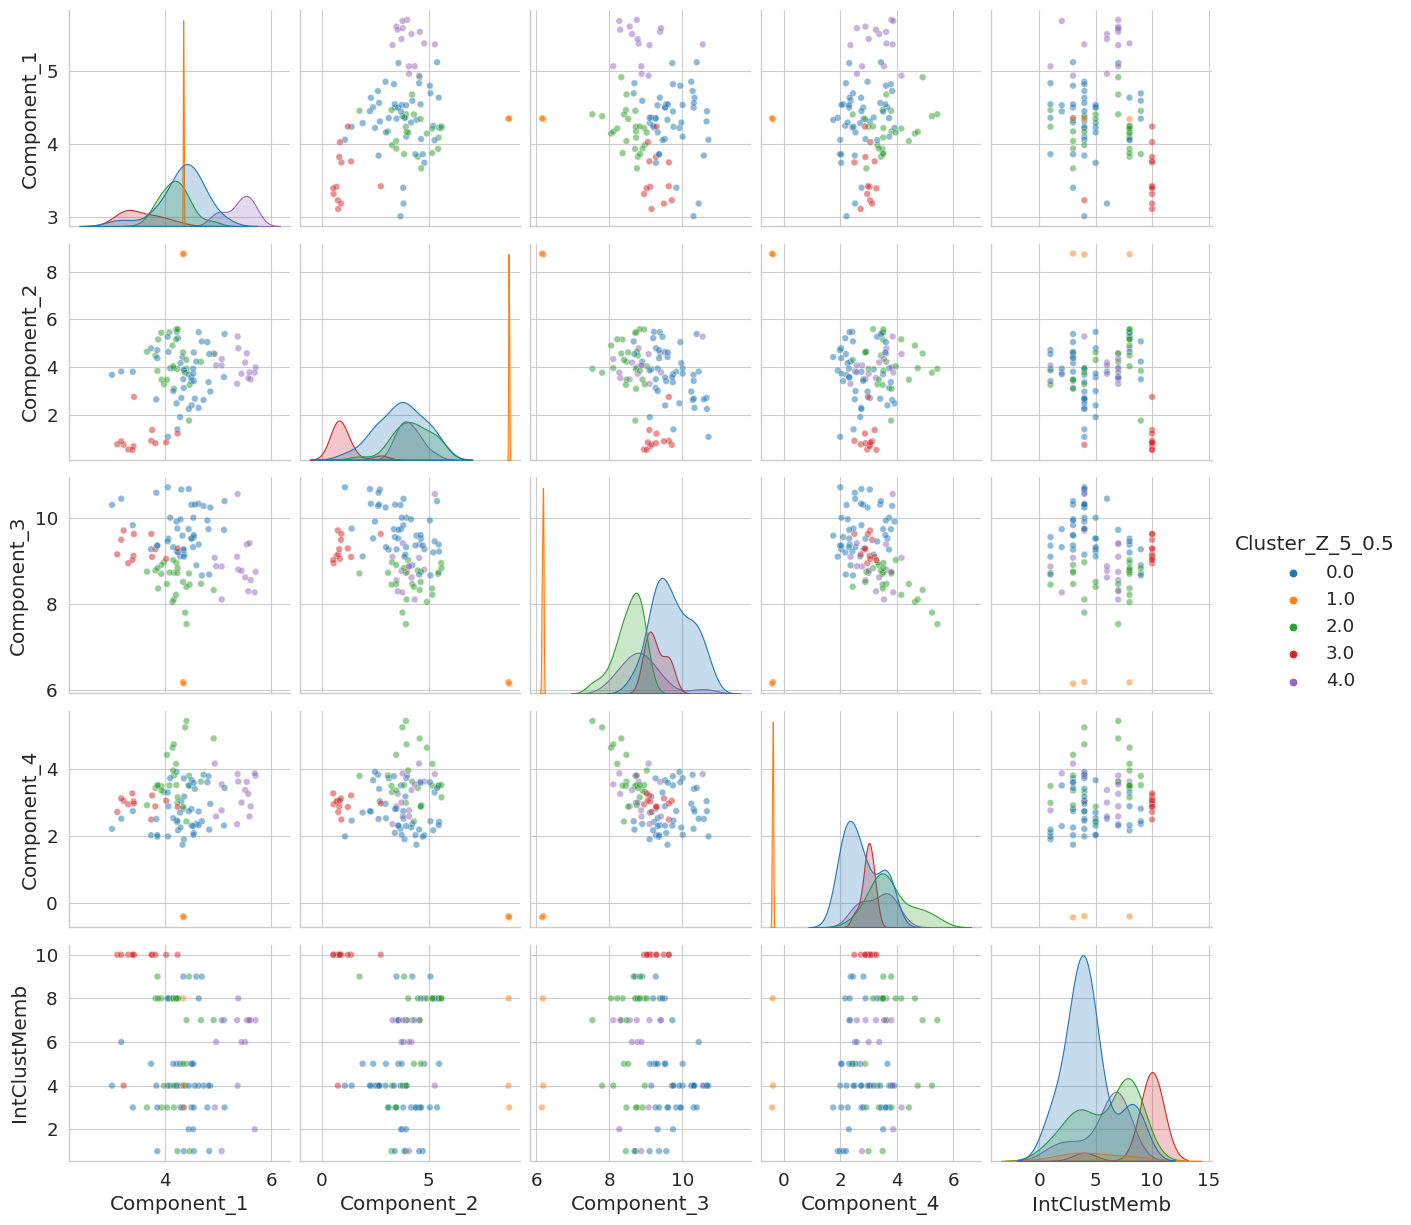

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
clust='Cluster_Z_5_0.5'
sns.pairplot(data_input_100.merge(quantumDf_real_100[[clust,'PATIENT_ID']],how='left',right_on=['PATIENT_ID'], left_on=[data_input_100.index]), hue=clust, palette='tab10', diag_kind='kde',plot_kws={'alpha':0.5})

In [ ]:
quantumDf_real_100[clust].value_counts()

Cluster_Z_5_0.5
0.0    45
2.0    25
4.0    15
3.0    12
1.0     3
Name: count, dtype: int64

Are they immortal?

Text(0, 0.5, 'Overall survival probability')

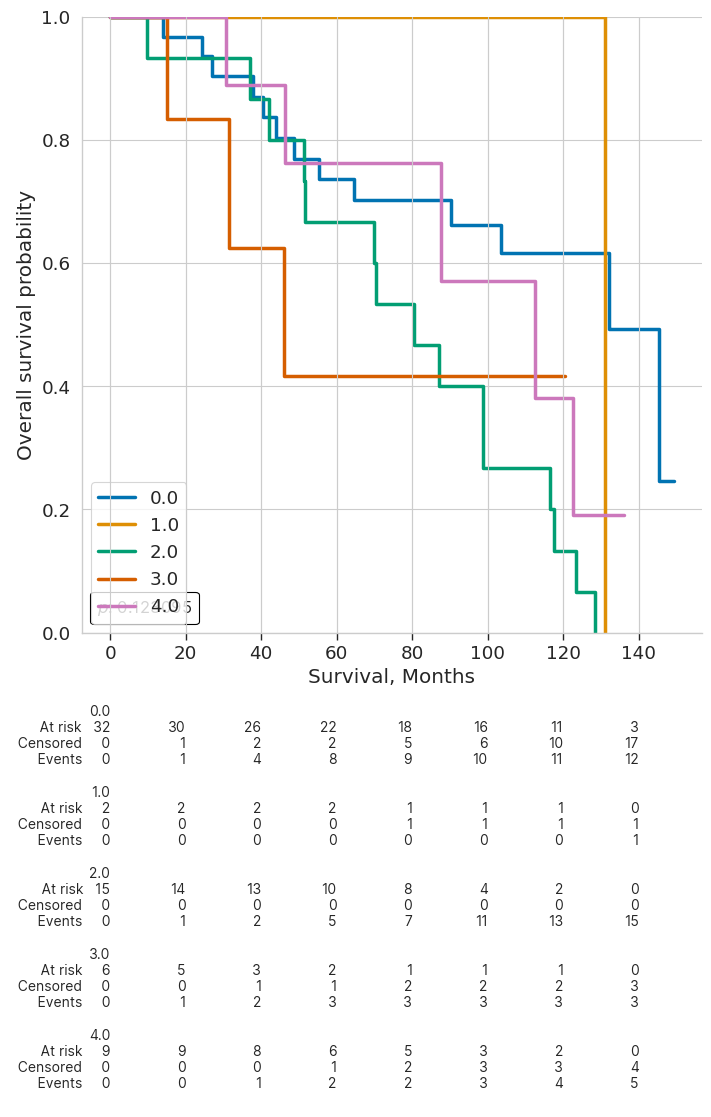

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plot_KM_curves(
    quantumDf_real_100.loc[quantumDf_real_100['OS_MONTHS'] <150 ], durationVar='OS_MONTHS',eventVar='OS_STATUS', indVar=clust, groups=[1,3], ax=ax, ci_show=False)
ax.set_xlabel('Survival, Months')
ax.set_ylabel('Overall survival probability')

Not immortal :(

### Simulated 1000

Let's check the highest scoring clusters for the simulatted 1000 case:

- Best ones according to the silhouette score (cut-off=0.3/ max 10 )
- Best ones according to the DI (max 10)

In [ ]:
quantumDf_s=quantumDf.copy()
for column in quantumDf_s.loc[:, ['INTCLUST','CLAUDIN_SUBTYPE']+cluster_col].columns:
    quantumDf_s[column] = quantumDf_s[column].apply(lambda x: f"{column}_{x}")

In [ ]:
df_1000=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_1000_umap/clustering_1000_opt_k_reviewed.csv',index_col=0)


In [ ]:
df_1000.replace('Z_full','Z',inplace=True)

In [ ]:
#Drop duplicated rbf cases due to bandwidth
df_1000=df_1000[(df_1000['ftmap'] != 'rbf') | (df_1000['Bandwidth'] == 1)]


Lets start with the silhouette

In [ ]:
df_1000.sort_values(by='silhouette',ascending=False,inplace=True)

In [ ]:
#Get only the  10 best with silhouette >0.3
df_1000[df_1000['silhouette']>0.3].iloc[:10]


ftmap   K  Bandwidth              s  geom_distance  concentration  \
135  ZZ_linear   2      0.125  127734.680535       9.484586       0.070194   
28         rbf   3      1.000   74501.173166       2.500972       0.029959   
136  ZZ_linear   3      0.125  127734.680535       9.484586       0.070194   
27         rbf   2      1.000   74501.173166       2.500972       0.029959   
29         rbf   4      1.000   74501.173166       2.500972       0.029959   
32         rbf   7      1.000   74501.173166       2.500972       0.029959   
30         rbf   5      1.000   74501.173166       2.500972       0.029959   
33         rbf   8      1.000   74501.173166       2.500972       0.029959   
31         rbf   6      1.000   74501.173166       2.500972       0.029959   
152  ZZ_linear  10      0.250   74836.101545       5.339809       0.080288   

     silhouette  Score_cluster         CHI        DI   v_intra   v_inter  \
135    0.628426       0.624934  154.232887  0.837206  0.056991  0.000647   
28     0.572370       0.620737  529.898257  0.000929  0.008170  0.032906   
136    0.551887       0.584336  408.213514  0.037421  0.025789  0.055347   
27     0.542565       0.548716  670.054354  0.001045  0.019163  0.025802   
29     0.419561       0.616219  547.824164  0.002553  0.005853  0.032249   
32     0.407904       0.719146  507.595970  0.001485  0.003319  0.029624   
30     0.404097       0.652419  525.682252  0.000729  0.005026  0.030578   
33     0.395397       0.734598  482.822831  0.002395  0.003016  0.029523   
31     0.392686       0.680109  481.499765  0.000729  0.004570  0.030022   
152    0.391744       0.602663  321.743957  0.032121  0.026329  0.051701   

     N_samples  
135       1000  
28        1000  
136       1000  
27        1000  
29        1000  
32        1000  
30        1000  
33        1000  
31        1000  
152       1000

Considering most of these are rbf, and thus not very usefull for us, we can proced and plot only the rbf ones to see cluster consistency between micro and macro clusters and then select one for reference to keep with the quantum

In [ ]:
cols_to_plot_rbf=[]
cols_name_rbf=[]

for i in df_1000[(df_1000['silhouette']>0.3) & (df_1000.ftmap=='rbf')].iloc[:10].itertuples():
    name='Cluster_'+i.ftmap+'_'+str((i.K))+'_'+f'{i.Bandwidth:g}'
    name_col='S:{:.2f}'.format(i.silhouette,i.DI)
    cols_name_rbf.append(name_col)
    cols_to_plot_rbf.append(name)

In [ ]:
fig=plotSankey(quantumDf_s, cols=cols_to_plot_rbf, names=cols_name_rbf, valueToHighlight=['High'], linkVar='CELLULARITY')

We can see that overall there are two macroclusters (+1 small other) one of which then tend to stratify (cluster 0.0) and the other which seems to be more consistent. we take for reference K=7



In [ ]:
rbf_clusters_s='Cluster_rbf_7_1'

Lets move onand take the best 5 quantum clusters

In [ ]:
df_1000[(df_1000['silhouette']>0.3) & (df_1000.ftmap!='rbf')].iloc[:5]

ftmap   K  Bandwidth              s  geom_distance  concentration  \
135  ZZ_linear   2      0.125  127734.680535       9.484586       0.070194   
136  ZZ_linear   3      0.125  127734.680535       9.484586       0.070194   
152  ZZ_linear  10      0.250   74836.101545       5.339809       0.080288   
151  ZZ_linear   9      0.250   74836.101545       5.339809       0.080288   
150  ZZ_linear   8      0.250   74836.101545       5.339809       0.080288   

     silhouette  Score_cluster         CHI        DI   v_intra   v_inter  \
135    0.628426       0.624934  154.232887  0.837206  0.056991  0.000647   
136    0.551887       0.584336  408.213514  0.037421  0.025789  0.055347   
152    0.391744       0.602663  321.743957  0.032121  0.026329  0.051701   
151    0.388783       0.573952  360.224697  0.029118  0.031645  0.050712   
150    0.375992       0.558809  229.956558  0.029195  0.035124  0.051325   

     N_samples  
135       1000  
136       1000  
152       1000  
151       1000  
150       1000

Since all the best clusters have been done with the ZZ linear we omit these in further plots to improve readability

In [ ]:
cols_to_plot_q = []
cols_name_q = []

for i in df_1000[(df_1000['silhouette']>0.3) & (df_1000.ftmap!='rbf')].iloc[:5].itertuples():
    name='Cluster_'+i.ftmap+'_'+str((i.K))+'_'+f'{i.Bandwidth:g}'
    name_col='b:{},S:{:.3f}'.format(i.Bandwidth,i.silhouette)
    cols_name_q.append(name_col)
    cols_to_plot_q.append(name)

In [ ]:
fig=plotSankey(quantumDf_s, cols=cols_to_plot_q, names=cols_name_q, valueToHighlight=['High'], linkVar='CELLULARITY')

As for the other cases we see once again how the stratification with lower k rapresents a macrostructure in ore data and tend to have a higher value of s due to the bias of the silhouette score.  There seems to be a good consistency also between the finer stratifications (K=10,9,8), and considering they came from the same kernel (ftmap=ZZ_linear, b=0.25) we decide to keep K=10 as a reference since it yields the best silhouette.

In [ ]:
q_cluster_s='Cluster_ZZ_linear_10_0.25'

Let's look at the best ones according to the DI

In [ ]:
df_1000.sort_values(by='DI',ascending=False,inplace=True)

In [ ]:
#Check the  10 best 
df_1000.iloc[:10]


ftmap   K  Bandwidth              s  geom_distance  concentration  \
135  ZZ_linear   2      0.125  127734.680535       9.484586       0.070194   
94           Z   6      0.125  212056.597796      16.760649       0.001171   
95           Z   7      0.125  212056.597796      16.760649       0.001171   
96           Z   8      0.125  212056.597796      16.760649       0.001171   
89     ZZ_full  10      2.000   90010.792065      25.414386       0.008016   
93           Z   5      0.125  212056.597796      16.760649       0.001171   
82     ZZ_full   3      2.000   90010.792065      25.414386       0.008016   
105          Z   8      0.250  154580.798965       8.371354       0.012575   
107          Z  10      0.250  154580.798965       8.371354       0.012575   
106          Z   9      0.250  154580.798965       8.371354       0.012575   

     silhouette  Score_cluster         CHI        DI   v_intra   v_inter  \
135    0.628426       0.624934  154.232887  0.837206  0.056991  0.000647   
94     0.244036       0.475554  450.758446  0.142593  0.001548  0.015123   
95     0.166334       0.435929  306.404099  0.122423  0.002044  0.015126   
96     0.114115       0.432576  262.378658  0.109097  0.002068  0.014980   
89     0.048231       0.092967   38.572960  0.102802  0.020632  0.005223   
93     0.261369       0.452608  482.960746  0.098428  0.002301  0.015573   
82     0.030379       0.039667  116.652572  0.092874  0.011679  0.004883   
105    0.317547       0.614840  437.464558  0.090453  0.001649  0.020288   
107    0.263067       0.611583  315.275127  0.088751  0.001785  0.020384   
106    0.286053       0.602580  345.848264  0.079558  0.002046  0.020407   

     N_samples  
135       1000  
94        1000  
95        1000  
96        1000  
89        1000  
93        1000  
82        1000  
105       1000  
107       1000  
106       1000

Select the first 5 for plotting

In [ ]:
cols_name_q_DI = []
cols_to_plot_q_DI = []
for i in df_1000.iloc[:5].itertuples():
    name='Cluster_'+i.ftmap+'_'+str((i.K))+'_'+f'{i.Bandwidth:g}'
    name_col='b:{},\nDI:{:.3f}'.format(i.Bandwidth,i.DI,i.silhouette)
    cols_name_q_DI.append(name_col)
    cols_to_plot_q_DI.append(name)

In [ ]:
print(cols_to_plot_q_DI)

['Cluster_ZZ_linear_2_0.125', 'Cluster_Z_6_0.125', 'Cluster_Z_7_0.125', 'Cluster_Z_8_0.125', 'Cluster_ZZ_full_10_2']


In [ ]:
fig=plotSankey(quantumDf_s, cols=cols_to_plot_q_DI, names=cols_name_q_DI, valueToHighlight=['High'], linkVar='CELLULARITY')

As before we can see that the case for K=2 is capturing the macrostructure of the data which consist of a number of subclusters, this phenomenon is due to the DI which is affected by the same bias of the silhouette score. We can also see that we have  a good level of consistency between 2nd 3rd and 4th clustering reported in the plot whereas the 5th is completly different, however it is also the one with the lowest DI and can be discharged from further analysis. Following the same approach used for the silhouette score we will keep the 2nd clustering since its the one with the best DI and considering the remaining fine stratification come form the same Kernel (ftmap:Z,b:0.125)


In [ ]:
q_cluster_DI='Cluster_Z_6_0.125'

Now we can put togheter quantum, rbf and known stratification (INTCLUST and CLAUDINE ) and look how they are :

- quantum vs classical
- quantum + claudin
- quantum + intclust
- 

In [ ]:
print(q_cluster_s,q_cluster_DI)

Cluster_ZZ_linear_10_0.25 Cluster_Z_6_0.125


In [ ]:
fig=plotSankey(quantumDf_s, cols=[q_cluster_DI,rbf_clusters_s,q_cluster_s], names=['Z_0.125 best_DI','rbf','ZZ_linear_0.25 best_s'], valueToHighlight=['High'], linkVar='CELLULARITY')

In [ ]:
print('AMI between rbf and ZZ_linear_0.25',adjusted_mutual_info_score(quantumDf_s[rbf_clusters_s],quantumDf_s[q_cluster_s]))
print('AMI between rbf and Z_0.125',adjusted_mutual_info_score(quantumDf_s[rbf_clusters_s],quantumDf_s[q_cluster_DI]))
print('AMI between ZZ_linear_0.25 and Z_0.125',adjusted_mutual_info_score(quantumDf_s[q_cluster_s],quantumDf_s[q_cluster_DI]))

AMI between rbf and ZZ_linear_0.25 0.619543600497348
AMI between rbf and Z_0.125 0.5063765832802456
AMI between ZZ_linear_0.25 and Z_0.125 0.4641176521182337


some consistency is present

Next:
- quantum vs Claudine

In [ ]:
fig=plotSankey(quantumDf_s, cols=[q_cluster_s,'CLAUDIN_SUBTYPE',q_cluster_DI], names=['ZZ_linear_0.25 (best_s)','CLAUDIN_SUBTYPE','Z_0.125 (best_DI)'], valueToHighlight=['High'], linkVar='CELLULARITY')

In [ ]:
print('AMI between quantum stratifications:',adjusted_mutual_info_score(quantumDf_s[q_cluster_s],quantumDf_s[q_cluster_DI]))
print('AMI between Claudin and ZZ_linear_0.25:',adjusted_mutual_info_score(quantumDf_s[q_cluster_s],quantumDf_s['CLAUDIN_SUBTYPE']))
print('AMI between Claudin and Z_0.125:',adjusted_mutual_info_score(quantumDf_s[q_cluster_DI],quantumDf_s['CLAUDIN_SUBTYPE']))

AMI between quantum stratifications: 0.4641176521182337
AMI between Claudin and ZZ_linear_0.25: 0.2204539149008424
AMI between Claudin and Z_0.125: 0.1956390672955398


Some consistency but not too much we can say

Next:
- quantum vs intclust

In [ ]:
fig=plotSankey(quantumDf_s, cols=[q_cluster_s,'INTCLUST',q_cluster_DI], names=['ZZ_linear_0.25 best_s','INTCLUST','Z_0.125 best_DI'], valueToHighlight=['High'], linkVar='CELLULARITY')

In [ ]:
print('AMI between INTCLUST and ZZ_linear_0.25:', adjusted_mutual_info_score(quantumDf_s[q_cluster_s],quantumDf_s['INTCLUST']))
print('AMI between INTCLUST and Z_0.125:', adjusted_mutual_info_score(quantumDf_s[q_cluster_DI],quantumDf_s['INTCLUST']))

AMI between INTCLUST and ZZ_linear_0.25: 0.22356490851066763
AMI between INTCLUST and Z_0.125: 0.19199088944027898


Very different again

In [ ]:
fig=plotSankey(quantumDf_s, cols=[q_cluster_s,q_cluster_DI]+['INTCLUST','CLAUDIN_SUBTYPE'] , valueToHighlight=['High'], linkVar='CELLULARITY')

Well they are not consistent not even between them :(

In [258]:
print('AMI between CLAUDIN and INTCLUST:', adjusted_mutual_info_score(quantumDf_s['CLAUDIN_SUBTYPE'],quantumDf_s['INTCLUST']))

AMI between CLAUDIN and INTCLUST: 0.24130552243880443


# Sample complexity

In [259]:
#Load all different sampling results
df_800=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_800_umap/clustering_800_opt_k_reviewed.csv',index_col=0)
df_500=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_500_umap/clustering_500_opt_k_reviewed.csv',index_col=0)
df_250=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_250_umap/clustering_250_opt_k_reviewed.csv',index_col=0)
df_50=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_50_umap/clustering_50_opt_k_reviewed.csv',index_col=0)

In [260]:
#Parse and correct data
df_800.replace('Z_full','Z',inplace=True)
df_500.replace('Z_full','Z',inplace=True)
df_250.replace('Z_full','Z',inplace=True)
df_50.replace('Z_full','Z',inplace=True)

In [261]:
df_clust_800=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_800_umap/clustering_800_clusters.csv',index_col=0)
df_clust_800.index=data_input.sample(n=800,axis=0,random_state=42).index
df_clust_500=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_500_umap/clustering_500_clusters.csv',index_col=0)
df_clust_500.index=data_input.sample(n=500,axis=0,random_state=42).index
df_clust_250=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_250_umap/clustering_250_clusters.csv',index_col=0)
df_clust_250.index=data_input.sample(n=250,axis=0,random_state=42).index
df_clust_50=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_50_umap/clustering_50_clusters.csv',index_col=0)
df_clust_50.index=data_input.sample(n=50,axis=0,random_state=42).index

In [262]:
df_clust_250.columns = df_clust_250.columns.str.replace("_Z_full", "_Z")
df_clust_500.columns = df_clust_500.columns.str.replace("_Z_full", "_Z")
df_clust_50.columns = df_clust_50.columns.str.replace("_Z_full", "_Z")


In [263]:
#check intersection between two sampling sizes
print('Intersection between 100 and 1000 samples:',len(set(df_clust_sim.index)&set(df_clust.index)))
print('Intersection between 100 and 1000 samples:',len(set(df_clust_sim.index)&set(df_clust.index)))
print('Intersection between 250 and 1000 samples:',len(set(df_clust_250.index)&set(df_clust.index)))
print('Intersection between 50 and 1000 samples:',len(set(df_clust_50.index)&set(df_clust.index)))

Intersection between 100 and 1000 samples: 100
Intersection between 100 and 1000 samples: 100
Intersection between 250 and 1000 samples: 250
Intersection between 50 and 1000 samples: 50


In [264]:
#Merge df_clust_sim and df_clust
df_sampling=df_clust.join(df_clust_sim,how='inner',lsuffix='_1000',rsuffix='_100')

df_sampling_250=df_clust.join(df_clust_250,how='inner',lsuffix='_1000',rsuffix='_250')
df_sampling_500=df_clust.join(df_clust_500,how='inner',lsuffix='_1000',rsuffix='_500')
df_sampling_50=df_clust.join(df_clust_50,how='inner',lsuffix='_1000',rsuffix='_50')



In [265]:
df_sampling_250.columns

Index(['Cluster_rbf_2_0.125_1000', 'Cluster_rbf_3_0.125_1000',
       'Cluster_rbf_4_0.125_1000', 'Cluster_rbf_5_0.125_1000',
       'Cluster_rbf_6_0.125_1000', 'Cluster_rbf_7_0.125_1000',
       'Cluster_rbf_8_0.125_1000', 'Cluster_rbf_9_0.125_1000',
       'Cluster_rbf_10_0.125_1000', 'Cluster_rbf_2_0.25_1000',
       ...
       'Cluster_ZZ_linear_10_1_250', 'Cluster_ZZ_linear_2_2_250',
       'Cluster_ZZ_linear_3_2_250', 'Cluster_ZZ_linear_4_2_250',
       'Cluster_ZZ_linear_5_2_250', 'Cluster_ZZ_linear_6_2_250',
       'Cluster_ZZ_linear_7_2_250', 'Cluster_ZZ_linear_8_2_250',
       'Cluster_ZZ_linear_9_2_250', 'Cluster_ZZ_linear_10_2_250'],
      dtype='object', length=360)

In [266]:
def AMI_ARI_calc(df,tag='_100'):
    #Caluculate ari and ami between same clusterings
    ami_ari_dict_list=[]
    for col in df.columns:
        if '_1000' not in col:
            break

        clust=col.split('_')
  

        if clust[1]=='Z':
            ftmap=clust[1]

        
        elif clust[1]=='ZZ':
            ftmap=clust[1]+'_'+clust[2]
        else:
            ftmap='rbf'
    
 
        ari=adjusted_rand_score(df['_'.join(clust[:-1])+'_1000'],df['_'.join(clust[:-1])+tag])
        nmi=normalized_mutual_info_score(df['_'.join(clust[:-1])+'_1000'],df['_'.join(clust[:-1])+tag])
        ami=adjusted_mutual_info_score(df['_'.join(clust[:-1])+'_1000'],df['_'.join(clust[:-1])+tag])
    


        ami_ari_dict_list.append({'ftmap':ftmap,
                              'K':clust[-3],
                              'Bandwidth':clust[-2],
                              'ARI':ari,
                              'NMI':nmi,
                              'AMI':ami})
    return pd.DataFrame(ami_ari_dict_list)



In [267]:
df_nmi_ari_100=AMI_ARI_calc(df_sampling,tag='_100')
df_nmi_ari_250=AMI_ARI_calc(df_sampling_250,tag='_250')
df_nmi_ari_500=AMI_ARI_calc(df_sampling_500,tag='_500')
df_nmi_ari_50=AMI_ARI_calc(df_sampling_50,tag='_50')    


In [268]:
for df in [df_nmi_ari_100,df_nmi_ari_250,df_nmi_ari_500,df_nmi_ari_50]:
    df[r'$\beta$']=df['Bandwidth'].map({'0.125':r'$\frac{\pi}{8}$','0.25':r'$\frac{\pi}{4}$','0.5':r'$\frac{\pi}{2}$','1':r'$\pi$','2':r'$2\pi$'})

In [269]:
to_concat=[df_nmi_ari_100,df_nmi_ari_250,df_nmi_ari_500,df_nmi_ari_50]
for df,n in zip(to_concat,[100,250,500,50]):
    df['Bandwidth']=df['Bandwidth'].astype(float)
    df['K']=df['K'].astype(int)
    df['Sampling']=[n]*len(df.index)
    df_new=df.merge(df_sim_1000,left_on=['ftmap','K','Bandwidth',r'$\beta$'],right_on=['ftmap','K','Bandwidth',r'$\beta$'])
    
df_nmi_ari=pd.concat(to_concat)



In [270]:
df_nmi_ari_new=df_nmi_ari.merge(df_sim_1000,left_on=['ftmap','K','Bandwidth',r'$\beta$'],right_on=['ftmap','K','Bandwidth',r'$\beta$'])
df_nmi_ari_new

ftmap   K  Bandwidth       ARI       NMI       AMI          $\beta$  \
0          rbf   2      0.125 -0.036213  0.025203  0.007628  $\frac{\pi}{8}$   
1          rbf   2      0.125  0.884573  0.815997  0.815342  $\frac{\pi}{8}$   
2          rbf   2      0.125  0.983052  0.959838  0.959766  $\frac{\pi}{8}$   
3          rbf   2      0.125  0.919597  0.871092  0.868984  $\frac{\pi}{8}$   
4          rbf   3      0.125  0.960132  0.930571  0.928469  $\frac{\pi}{8}$   
..         ...  ..        ...       ...       ...       ...              ...   
715  ZZ_linear   9      2.000  0.208645  0.535474  0.301893           $2\pi$   
716  ZZ_linear  10      2.000  0.144174  0.388300  0.224831           $2\pi$   
717  ZZ_linear  10      2.000  0.215514  0.409694  0.356981           $2\pi$   
718  ZZ_linear  10      2.000  0.339082  0.495100  0.475144           $2\pi$   
719  ZZ_linear  10      2.000  0.274741  0.609716  0.378063           $2\pi$   

     Sampling  Unnamed: 0             s  geom_distance  concentration  \
0         100           0  74501.173166       2.500972       0.029959   
1         250           0  74501.173166       2.500972       0.029959   
2         500           0  74501.173166       2.500972       0.029959   
3          50           0  74501.173166       2.500972       0.029959   
4         100           1  74501.173166       2.500972       0.029959   
..        ...         ...           ...            ...            ...   
715        50         178  95407.786367      30.625621       0.012059   
716       100         179  95407.786367      30.625621       0.012059   
717       250         179  95407.786367      30.625621       0.012059   
718       500         179  95407.786367      30.625621       0.012059   
719        50         179  95407.786367      30.625621       0.012059   

     silhouette  Score_cluster         CHI        DI   v_intra   v_inter  \
0      0.542565       0.548716  670.054354  0.001045  0.019163  0.025802   
1      0.542565       0.548716  670.054354  0.001045  0.019163  0.025802   
2      0.542565       0.548716  670.054354  0.001045  0.019163  0.025802   
3      0.542565       0.548716  670.054354  0.001045  0.019163  0.025802   
4      0.572370       0.620737  529.898257  0.000929  0.008170  0.032906   
..          ...            ...         ...       ...       ...       ...   
715    0.078879       0.129285   14.854635  0.040077  0.032118  0.006810   
716    0.076810       0.137537   22.698114  0.059592  0.033233  0.006988   
717    0.076810       0.137537   22.698114  0.059592  0.033233  0.006988   
718    0.076810       0.137537   22.698114  0.059592  0.033233  0.006988   
719    0.076810       0.137537   22.698114  0.059592  0.033233  0.006988   

     N_samples       Type  
0         1000  Simulated  
1         1000  Simulated  
2         1000  Simulated  
3         1000  Simulated  
4         1000  Simulated  
..         ...        ...  
715       1000  Simulated  
716       1000  Simulated  
717       1000  Simulated  
718       1000  Simulated  
719       1000  Simulated  

[720 rows x 20 columns]

(0.0, 1.05)

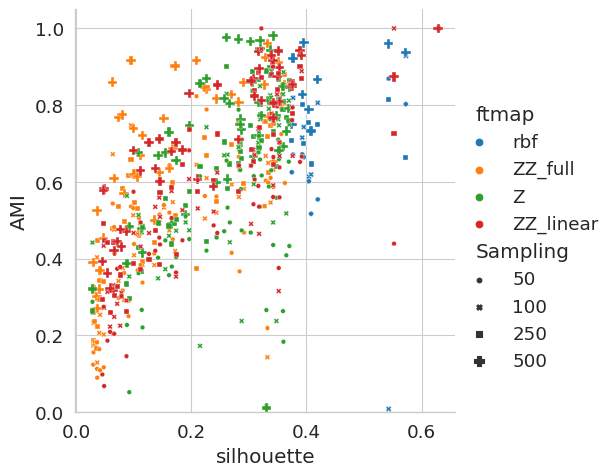

In [271]:
#Plot
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.relplot(data=df_nmi_ari_new,hue='ftmap',
             y='AMI',x='silhouette',style='Sampling',size='Sampling',markers=True,palette='tab10')
plt.ylim(0.00,1.05)

(0.0, 1.05)

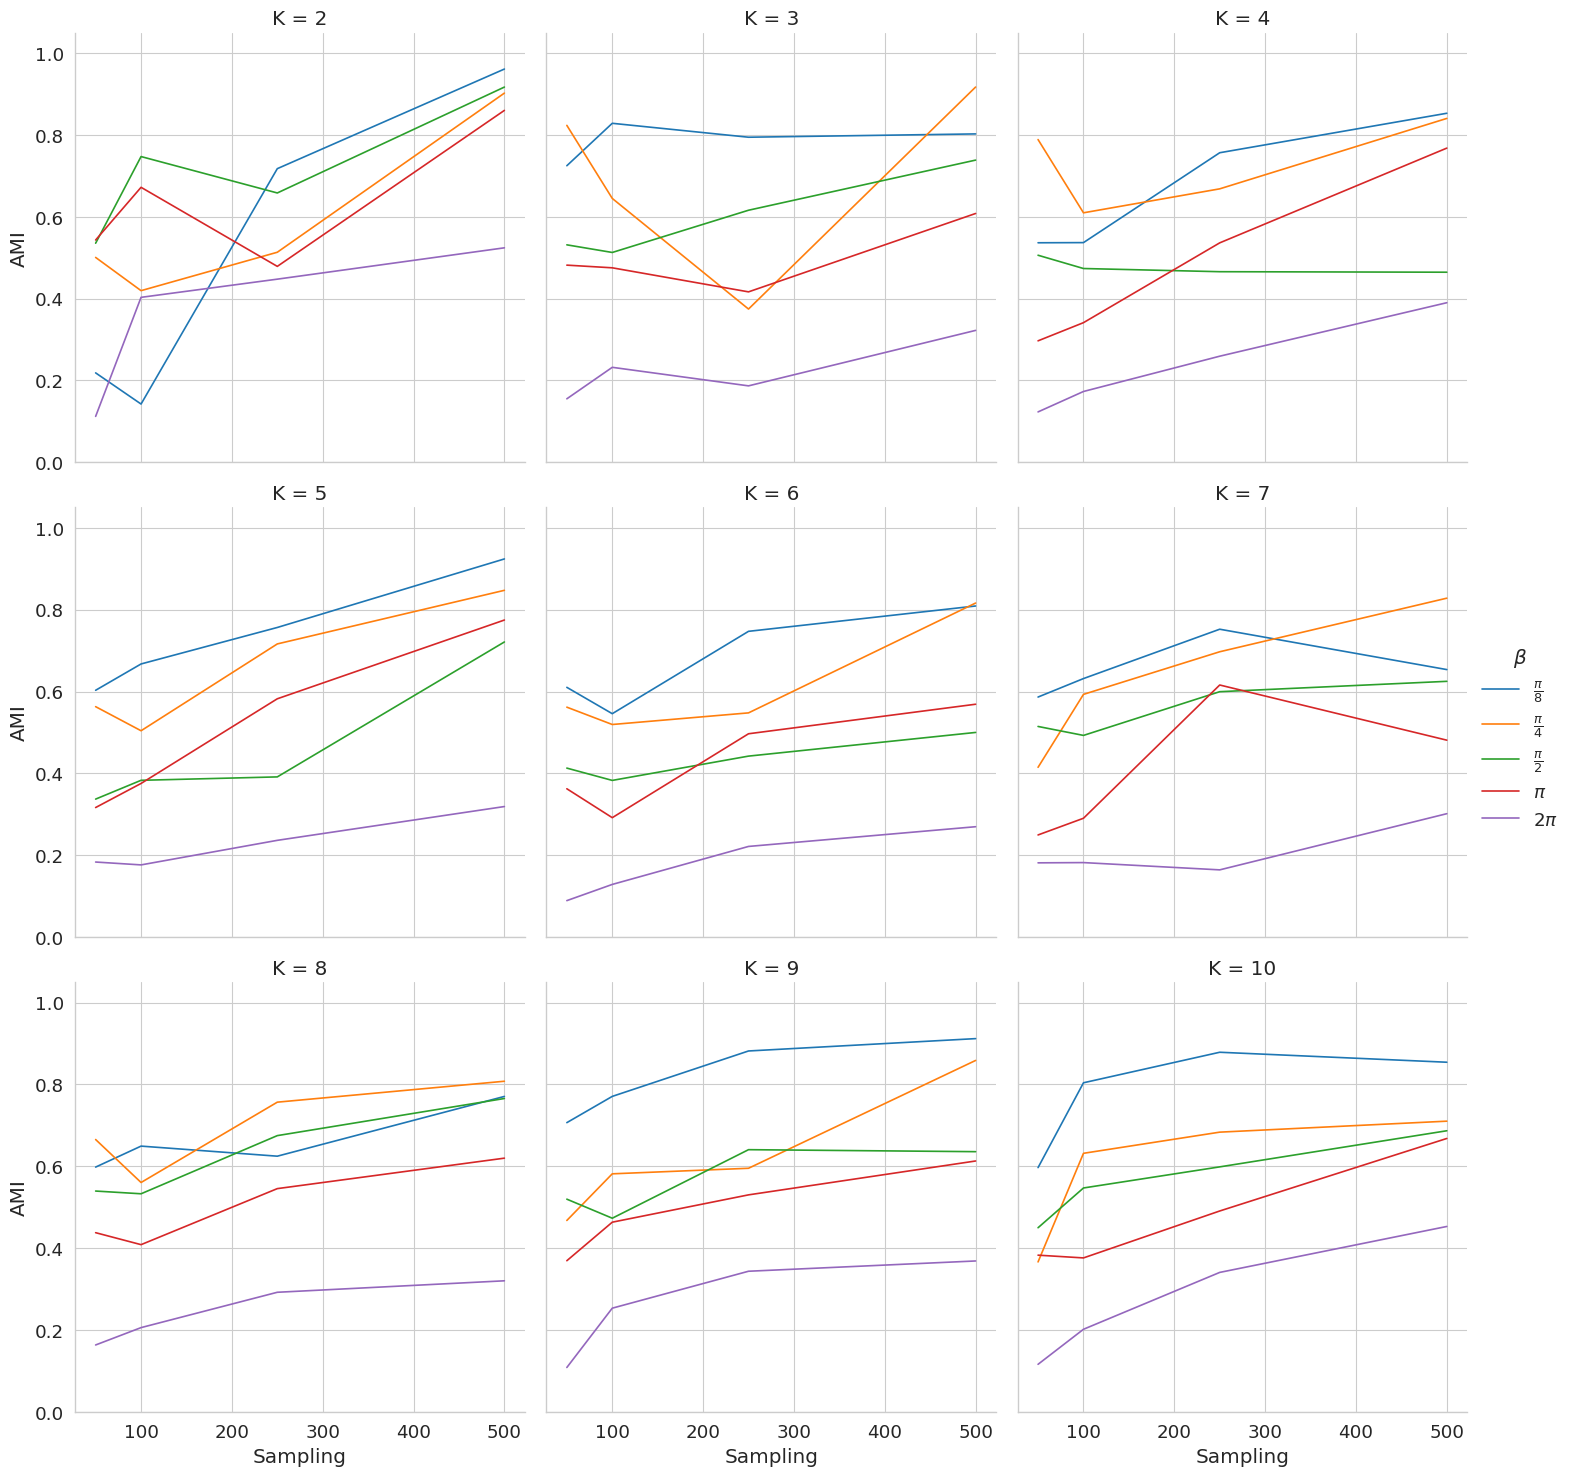

In [272]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.relplot(data=df_nmi_ari_new[(df_nmi_ari_new['ftmap']=='ZZ_full')],col='K',col_wrap=3,kind='line',
             y='AMI',x='Sampling',hue=r'$\beta$',markers=True,palette='tab10')
plt.ylim(0.00,1.05)

In [273]:
df_nmi_ari_new['Clust']=df_nmi_ari_new['ftmap']+'_'+df_nmi_ari_new['K'].astype(str)+'_'+df_nmi_ari_new[r'$\beta$'].astype(str)

In [274]:
#New column quantum/classical
df_nmi_ari_new['Quantum/Classical']=df_nmi_ari_new['ftmap'].apply(lambda x: 'Quantum' if x!='rbf' else 'Classical')

(0.0, 1.05)

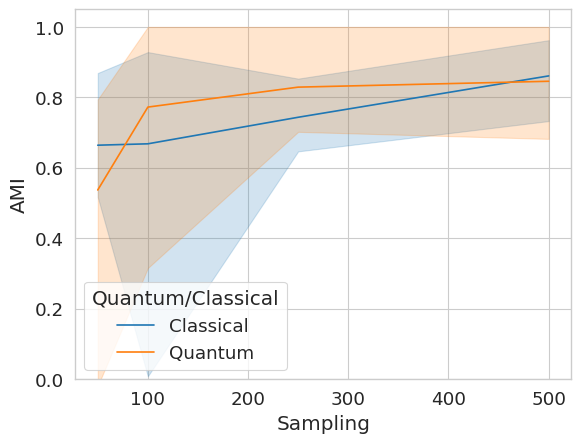

In [275]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.lineplot(data=df_nmi_ari_new[(df_nmi_ari_new.silhouette>0.35)],
             y='AMI',x='Sampling',hue='Quantum/Classical',errorbar=('pi',100),err_style='band',markers=True,palette='tab10')
plt.ylim(0.00,1.05)

In [276]:
df_nmi_ari_new[(df_nmi_ari_new.silhouette>0.35)].value_counts('Quantum/Classical')

Quantum/Classical
Classical    180
Quantum       76
Name: count, dtype: int64

In [303]:
df_nmi_ari_new['Clust_2']=df_nmi_ari_new['ftmap']+'_'+df_nmi_ari_new[r'$\beta$'].astype(str)

In [277]:
#Drop rbf bandwidth !=1
to_drop=df_nmi_ari_new[(df_nmi_ari_new.ftmap=='rbf') & (df_nmi_ari_new.Bandwidth!=1)].index
df_nmi_ari_new.drop(to_drop,axis=0,inplace=True)


/tmp/ipykernel_286949/177474617.py:2: UserWarning:


The markers list has fewer values (12) than needed (28) and will cycle, which may produce an uninterpretable plot.



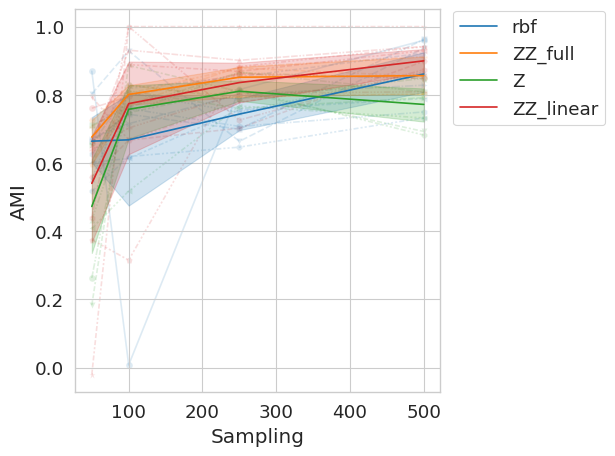

In [278]:
markers = ["o", "v", "^", "<", ">", "8", "s", "*", "h", "H", "P", "p"]
ax = sns.lineplot(data=df_nmi_ari_new[(df_nmi_ari_new.silhouette >= 0.35)], 
                  x='Sampling', y='AMI', hue='ftmap', markers=markers,style='Clust',palette='tab10',legend=False,alpha=0.15)
for dots in ax.collections:
    color = dots.get_facecolor()
    dots.set_color(sns.set_hls_values(color, l=0.7))
    dots.set_alpha(0.05)
for line in ax.lines:
    line.set_zorder(0)

sns.lineplot(data=df_nmi_ari_new[(df_nmi_ari_new.silhouette >= 0.35)], x='Sampling', y='AMI', hue='ftmap',errorbar=('ci',95) ,palette='tab10')
ax.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipykernel_286949/319463125.py:2: UserWarning:

The markers list has more values (11) than needed (9), which may not be intended.



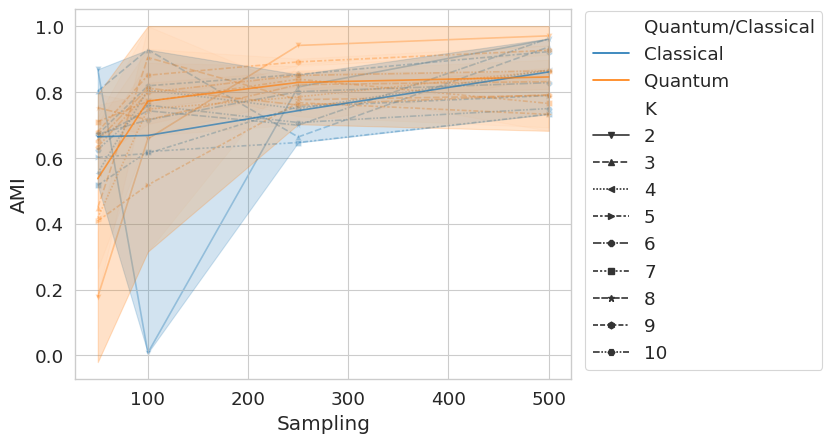

In [338]:
markers = [ "v", "^", "<", ">", "8", "s", "*", "h", "H", "P", "p"]
ax = sns.lineplot(data=df_nmi_ari_new[(df_nmi_ari_new.silhouette >= 0.35)], 
                  x='Sampling', y='AMI', hue='Quantum/Classical', markers=markers,style='K',palette='tab10',legend=True,alpha=0.35)
for dots in ax.collections:
    color = dots.get_facecolor()
    dots.set_color(sns.set_hls_values(color, l=0.7))
    dots.set_alpha(0.05)
for line in ax.lines:
    line.set_zorder(0)

sns.lineplot(data=df_nmi_ari_new[(df_nmi_ari_new.silhouette >= 0.35)], 
             x='Sampling', y='AMI', hue='Quantum/Classical',errorbar=('pi',100), err_style='band',legend=False,palette='tab10',alpha=0.7)
ax.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left')
#plt.tight_layout()
plt.show()

In [343]:
df_nmi_ari_new['Clust_2'].replace(r'rbf_$\pi$','rbf',inplace=True)

/tmp/ipykernel_286949/821686834.py:2: UserWarning:

The markers list has more values (12) than needed (2), which may not be intended.



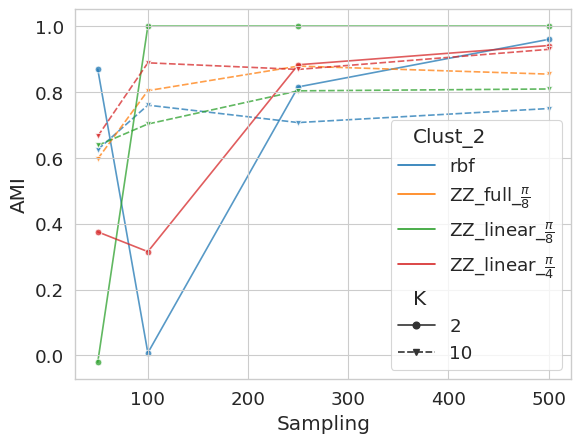

In [344]:
markers = ["o", "v", "^", "<", ">", "8", "s", "*", "h", "H", "P", "p"]
ax = sns.lineplot(data=df_nmi_ari_new[(df_nmi_ari_new.silhouette >= 0.35)& (df_nmi_ari_new.K.isin([10,2]))], 
                  x='Sampling', y='AMI', style='K', markers=markers,hue='Clust_2',palette='tab10',legend=True,alpha=0.75)
for dots in ax.collections:
    color = dots.get_facecolor()
    dots.set_color(sns.set_hls_values(color, l=0.7))
    dots.set_alpha(0.05)
for line in ax.lines:
    line.set_zorder(0)


/tmp/ipykernel_286949/3161627258.py:8: UserWarning:


The markers list has fewer values (12) than needed (28) and will cycle, which may produce an uninterpretable plot.

/tmp/ipykernel_286949/3161627258.py:15: UserWarning:

The markers list has more values (12) than needed (4), which may not be intended.

/tmp/ipykernel_286949/3161627258.py:16: UserWarning:

The markers list has more values (12) than needed (4), which may not be intended.

/tmp/ipykernel_286949/3161627258.py:22: UserWarning:

The markers list has more values (12) than needed (3), which may not be intended.

/tmp/ipykernel_286949/3161627258.py:23: UserWarning:

The markers list has more values (12) than needed (3), which may not be intended.



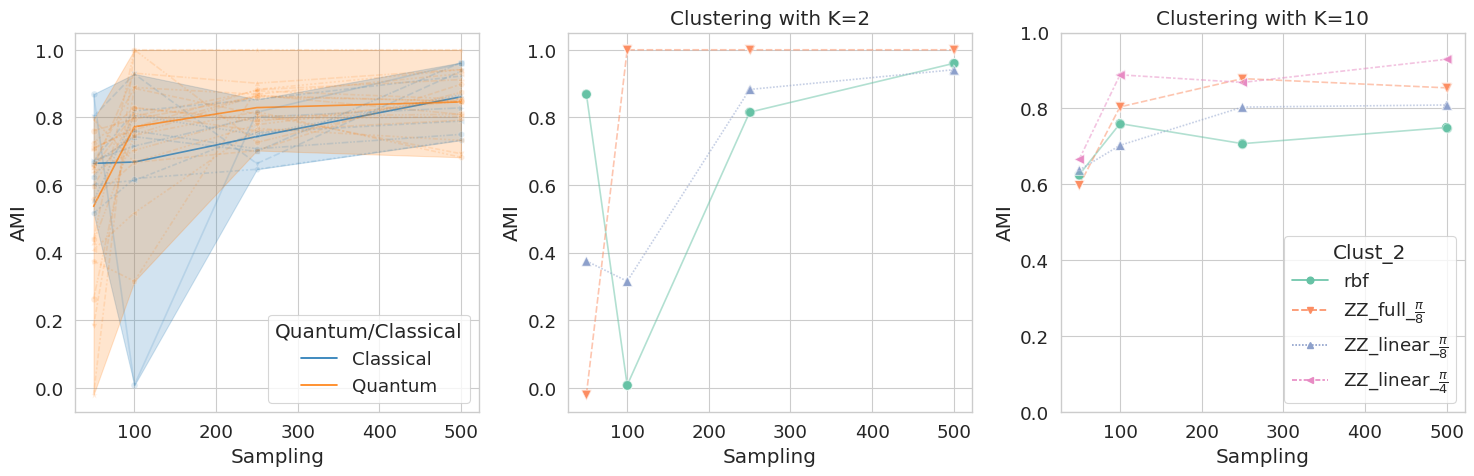

In [365]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Define markers
markers = ["o", "v", "^", "<", ">", "8", "s", "*", "h", "H", "P", "p"]
#Plot all above 0.35 with mean
sns.lineplot(ax=axes[0],data=df_nmi_ari_new[(df_nmi_ari_new.silhouette >= 0.35)], 
             x='Sampling', y='AMI', hue='Quantum/Classical', err_style='band',errorbar=('pi',100),legend=True,palette='tab10',alpha=0.75)
sns.lineplot(ax=axes[0],data=df_nmi_ari_new[(df_nmi_ari_new.silhouette >= 0.35)], 
                  x='Sampling', y='AMI', hue='Quantum/Classical', markers=markers,style='Clust',palette='tab10',legend=False,alpha=0.15)
# Filter data for K=10 and K=2
data_k10 = df_nmi_ari_new[(df_nmi_ari_new.silhouette >= 0.35) & (df_nmi_ari_new.K == 10)]
data_k2 = df_nmi_ari_new[(df_nmi_ari_new.silhouette >= 0.35) & (df_nmi_ari_new.K == 2)]

# Plot for K=10
sns.lineplot(ax=axes[2], data=data_k10, x='Sampling', y='AMI', style='Clust_2', markers=markers,markersize=7, hue='Clust_2', palette='Set2', legend=True, alpha=0.5)
sns.scatterplot(ax=axes[2], data=data_k10, x='Sampling', y='AMI', style='Clust_2', markers=markers,s=53,hue='Clust_2', palette='Set2', legend=False)
sns.move_legend(axes[2], "lower right")
axes[2].set_title('Clustering with K=10')


# Plot for K=2
sns.lineplot(ax=axes[1], data=data_k2, x='Sampling', y='AMI', style='Clust_2',markersize=7,markers=markers, hue='Clust_2', palette='Set2', legend=False, alpha=0.5)
sns.scatterplot(ax=axes[1], data=data_k2, x='Sampling', y='AMI', style='Clust_2',s=53,markers=markers, hue='Clust_2', palette='Set2', legend=False)
axes[1].set_title('Clustering with K=2')


# Adjust layout
plt.ylim(0.00,1.0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_286949/2604425630.py:1: UserWarning:

The markers list has more values (12) than needed (6), which may not be intended.



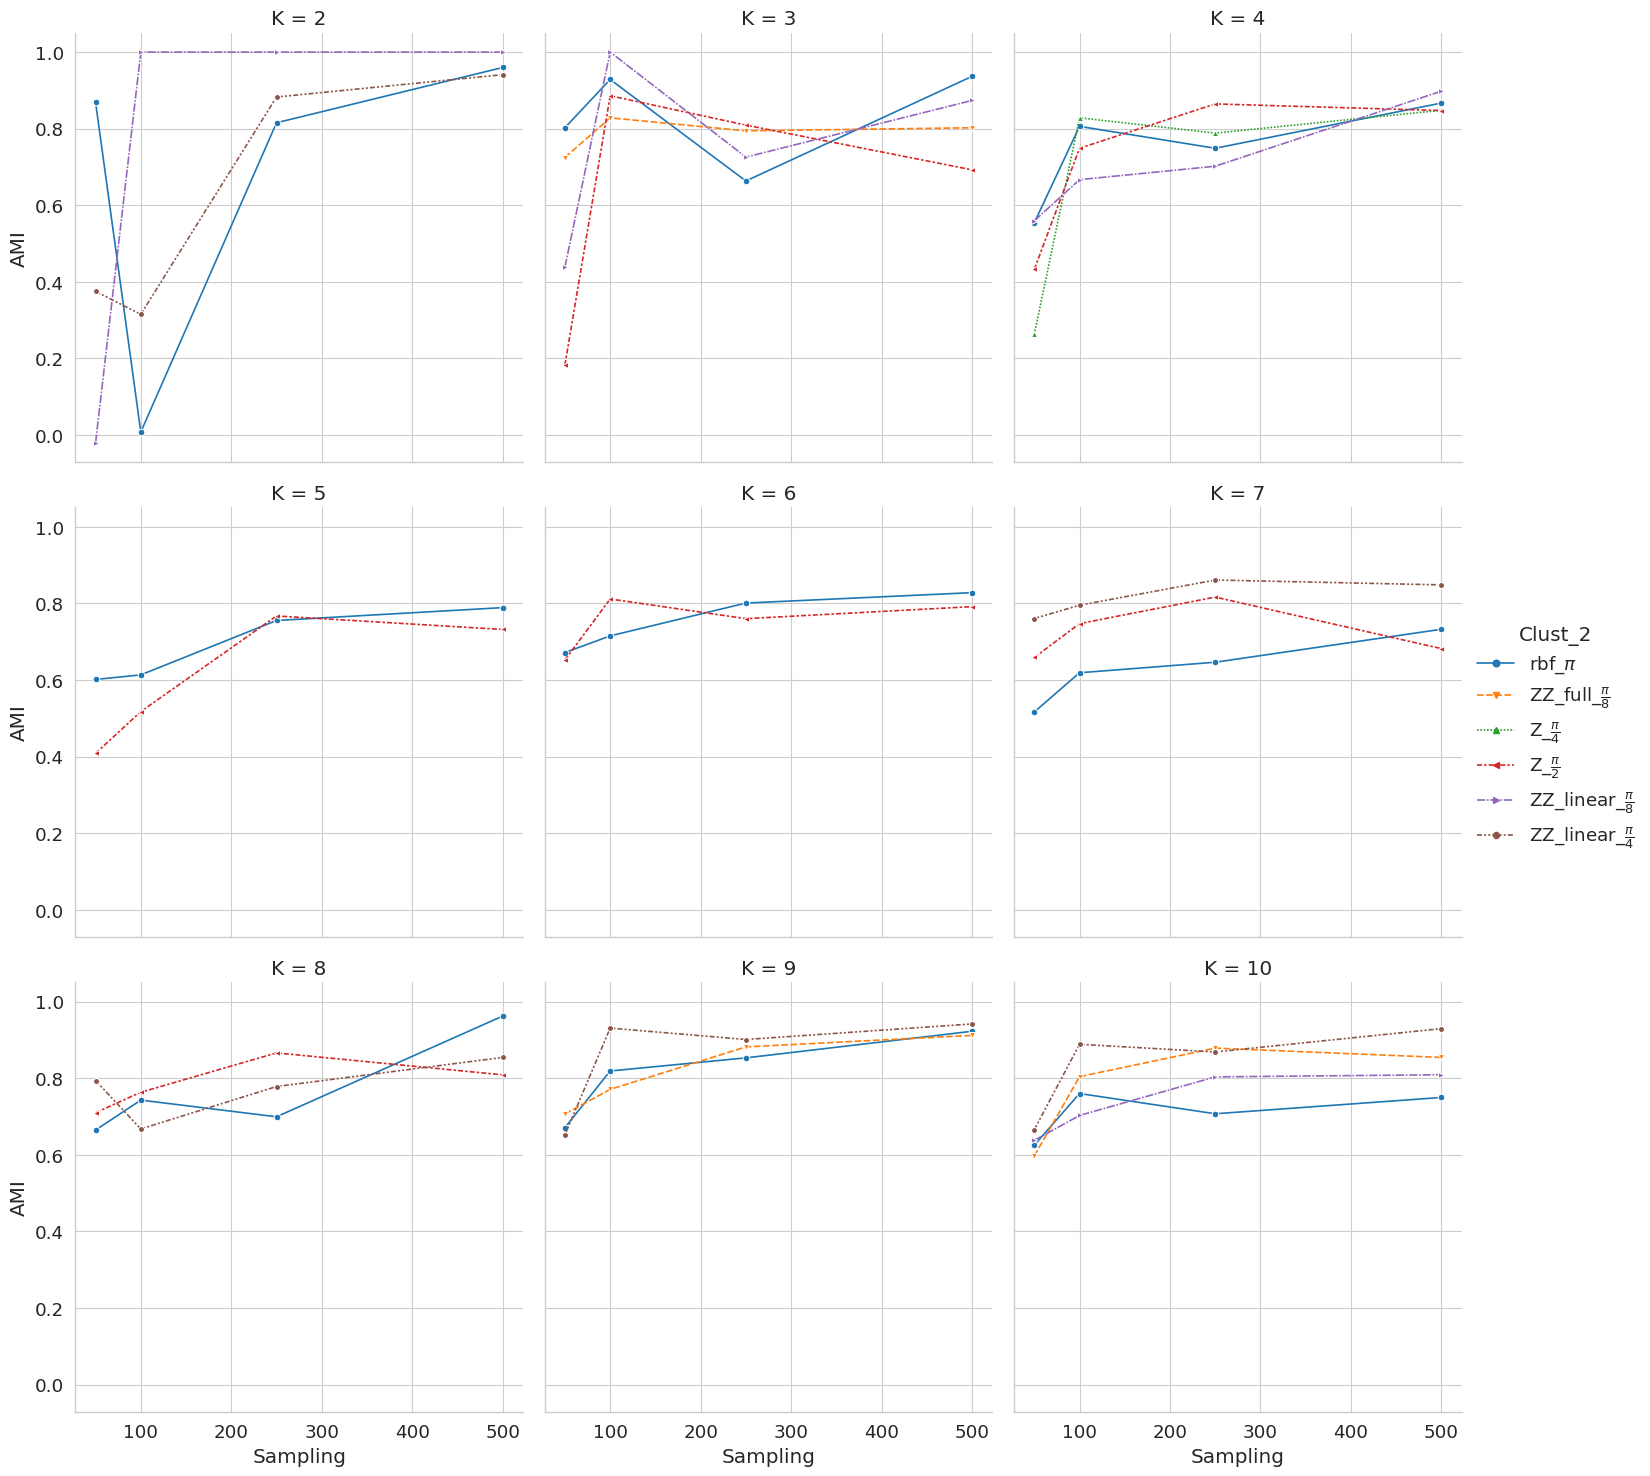

In [318]:
sns.relplot(data=df_nmi_ari_new[(df_nmi_ari_new.silhouette >= 0.35)],
             style='Clust_2', markers=markers, x='Sampling', y='AMI', hue='Clust_2', palette='tab10',col='K',col_wrap=3,kind='line')

/tmp/ipykernel_286949/93421382.py:1: UserWarning:

The markers list has more values (12) than needed (5), which may not be intended.



<Axes: xlabel='Sampling', ylabel='AMI'>

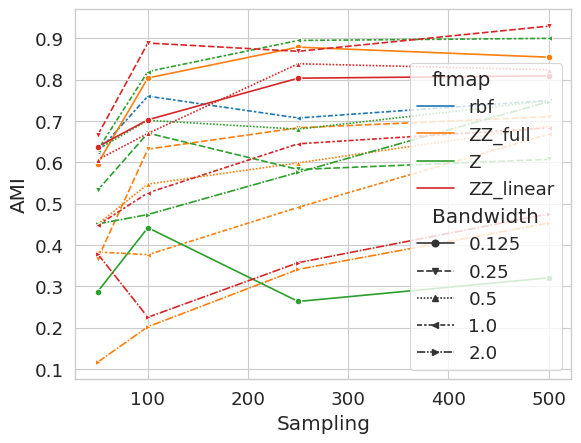

In [358]:
sns.lineplot(data=df_nmi_ari_new[(df_nmi_ari_new.K==10) ], 
                  x='Sampling', y='AMI', hue='ftmap', markers=markers,style='Bandwidth',palette='tab10',alpha=1)


In [280]:
for df,n in zip([df_50,df_250,df_500,df_sim,df_sim_1000],[50,250,500,100,1000]):
    df['Sampling']=[n]*len(df.index)

df_s_ami=pd.concat([df_50,df_250,df_500,df_sim,df_sim_1000])
df_s_ami.drop(['Unnamed: 0','Type'],axis=1,inplace=True)

In [281]:
df_s_ami.drop(r'$\beta$',axis=1,inplace=True)

In [282]:
df_s_ami=df_s_ami.merge(df_1000[['ftmap','K','Bandwidth','silhouette']],on=['ftmap','K','Bandwidth'],how='inner',suffixes=('','_1000'))

In [283]:
df_s_ami['Quantum/Classical']=df_s_ami['ftmap'].apply(lambda x: 'Quantum' if x!='rbf' else 'Classical')

(0.0, 1.0)

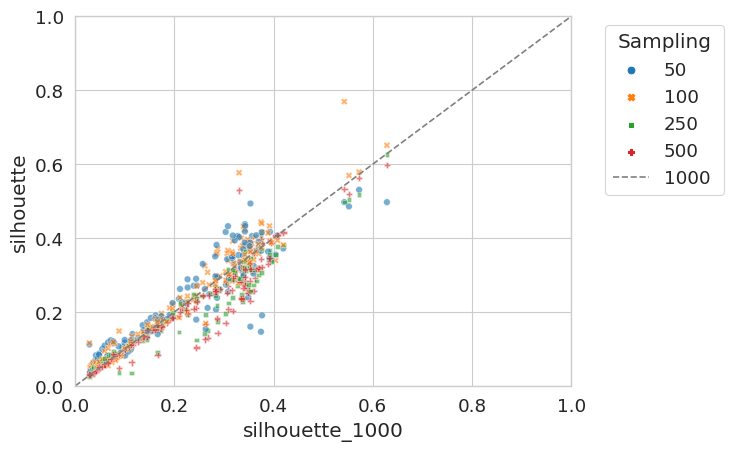

In [284]:
sns.scatterplot(data=df_s_ami[df_s_ami.Sampling!=1000], x='silhouette_1000', y='silhouette', hue='Sampling',style='Sampling',palette='tab10',alpha=0.6)
plt.plot([-0.1,1],[-0.1,1],color='grey',linestyle='--',label='1000 ')
  # Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Sampling')
plt.ylim(0.0,1)
plt.xlim(0.0,1)

In [ ]:
common_col=list(set(df_s_ami.columns)& set(df_nmi_ari_new.columns))
df_prova=df_s_ami.merge(df_nmi_ari_new.drop(['silhouette'],axis=1), on=['ftmap','K','Bandwidth','Quantum/Classical'],how='inner')

### Only 100

In [212]:
df_sim['Bandwidth']=df_sim['Bandwidth'].astype(float)
df_sim['K']=df_sim['K'].astype(int)
df_nmi_ari_100['Bandwidth']=df_nmi_ari_100['Bandwidth'].astype(float)
df_nmi_ari_100['K']=df_nmi_ari_100['K'].astype(int)
df=df_nmi_ari_100.merge(df_sim_1000,left_on=['ftmap','K','Bandwidth',r'$\beta$'],right_on=['ftmap','K','Bandwidth',r'$\beta$'])

(0.0, 1.05)

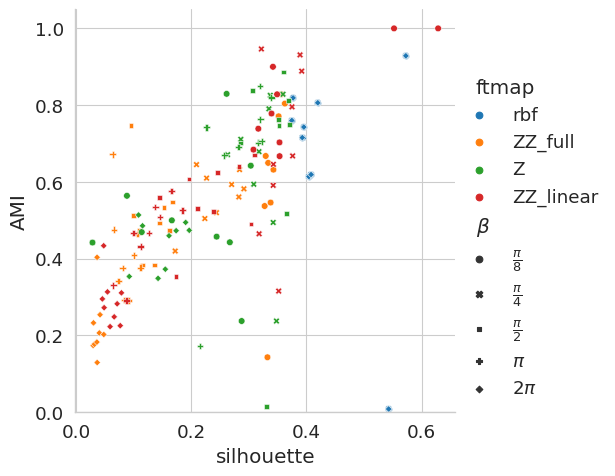

In [ ]:
#Plot
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.relplot(data=df,
             y='AMI',x='silhouette',hue='ftmap',style=r'$\beta$',markers=True,palette='tab10')
plt.ylim(0.00,1.05)


In [ ]:
df

ftmap   K  Bandwidth       ARI       NMI       AMI        $\beta$_x  \
0          rbf   2      0.125 -0.036213  0.025203  0.007628  $\frac{\pi}{8}$   
1          rbf   3      0.125  0.960132  0.930571  0.928469  $\frac{\pi}{8}$   
2          rbf   4      0.125  0.749738  0.814390  0.805991  $\frac{\pi}{8}$   
3          rbf   5      0.125  0.476494  0.637160  0.613408  $\frac{\pi}{8}$   
4          rbf   6      0.125  0.603511  0.739067  0.715228  $\frac{\pi}{8}$   
..         ...  ..        ...       ...       ...       ...              ...   
175  ZZ_linear   6      2.000  0.149792  0.288728  0.222347           $2\pi$   
176  ZZ_linear   7      2.000  0.133620  0.332845  0.247883           $2\pi$   
177  ZZ_linear   8      2.000  0.150828  0.385798  0.281938           $2\pi$   
178  ZZ_linear   9      2.000  0.179443  0.433988  0.310469           $2\pi$   
179  ZZ_linear  10      2.000  0.144174  0.388300  0.224831           $2\pi$   

     Unnamed: 0             s  geom_distance  concentration  silhouette  \
0             0  74501.173166       2.500972       0.029959    0.542565   
1             1  74501.173166       2.500972       0.029959    0.572370   
2             2  74501.173166       2.500972       0.029959    0.419561   
3             3  74501.173166       2.500972       0.029959    0.404097   
4             4  74501.173166       2.500972       0.029959    0.392686   
..          ...           ...            ...            ...         ...   
175         175  95407.786367      30.625621       0.012059    0.059177   
176         176  95407.786367      30.625621       0.012059    0.066313   
177         177  95407.786367      30.625621       0.012059    0.071467   
178         178  95407.786367      30.625621       0.012059    0.078879   
179         179  95407.786367      30.625621       0.012059    0.076810   

     Score_cluster         CHI        DI   v_intra   v_inter  N_samples  \
0         0.548716  670.054354  0.001045  0.019163  0.025802       1000   
1         0.620737  529.898257  0.000929  0.008170  0.032906       1000   
2         0.616219  547.824164  0.002553  0.005853  0.032249       1000   
3         0.652419  525.682252  0.000729  0.005026  0.030578       1000   
4         0.680109  481.499765  0.000729  0.004570  0.030022       1000   
..             ...         ...       ...       ...       ...        ...   
175       0.092081   18.865565  0.057337  0.024971  0.006753       1000   
176       0.108621   19.229838  0.036725  0.027800  0.006833       1000   
177       0.120354   17.781279  0.069038  0.030029  0.006863       1000   
178       0.129285   14.854635  0.040077  0.032118  0.006810       1000   
179       0.137537   22.698114  0.059592  0.033233  0.006988       1000   

          Type        $\beta$_y  
0    Simulated  $\frac{\pi}{8}$  
1    Simulated  $\frac{\pi}{8}$  
2    Simulated  $\frac{\pi}{8}$  
3    Simulated  $\frac{\pi}{8}$  
4    Simulated  $\frac{\pi}{8}$  
..         ...              ...  
175  Simulated           $2\pi$  
176  Simulated           $2\pi$  
177  Simulated           $2\pi$  
178  Simulated           $2\pi$  
179  Simulated           $2\pi$  

[180 rows x 20 columns]

/tmp/ipykernel_3405210/2166903225.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df[df['ftmap'].isin([ft_map])], x='silhouette',
/tmp/ipykernel_3405210/2166903225.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df[df['ftmap'].isin([ft_map])], x='silhouette',
/tmp/ipykernel_3405210/2166903225.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df[df['ftmap'].isin([ft_map])], x='silhouette',


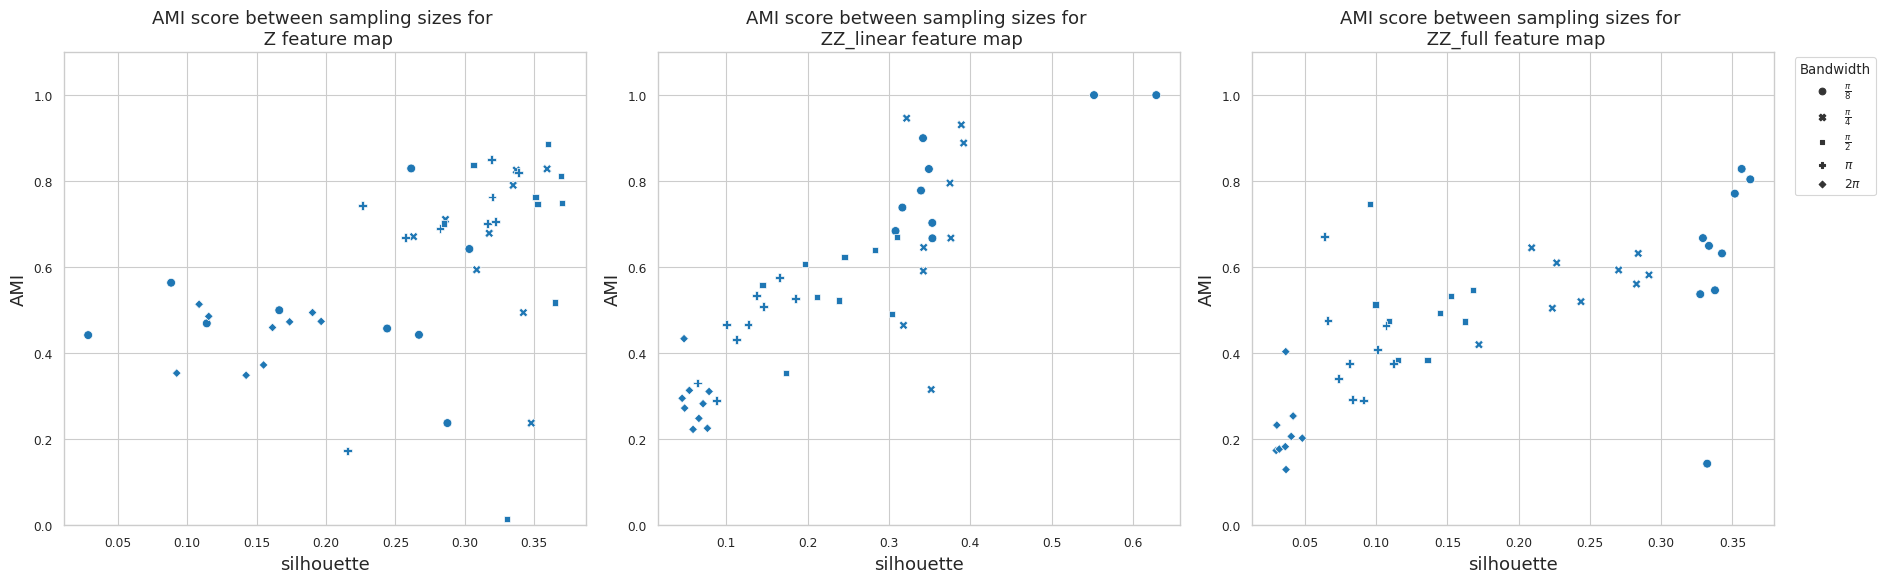

In [ ]:
    
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
score_to_plot='AMI'
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":13,"axes.labelsize":13,})
# Iterate over each feature map
for i, ft_map in enumerate(['Z', 'ZZ_linear', 'ZZ_full']):
    # Filter the dataframe for the current feature map
    #ft_map_df = df[df['ftmap'] == ft_map]
    
    # Plot the data in the corresponding subplot
    ax = axs[i]
    sns.scatterplot(data=df[df['ftmap'].isin([ft_map])], x='silhouette',
                  y=score_to_plot, style=r'$\beta$', markers=True, palette='tab10', ax=ax, s=40)
    
    # Move the legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set the plot title
    ax.set_title('{} score between sampling sizes for \n {} feature map'.format(score_to_plot, ft_map))
    
    # Set the y-axis limits
    ax.set_ylim(0, 1.1)
    #ax.set_xlim(0,0.4)

    if i != 4:
        ax.legend_.remove()

# Get handles and labels for legend from the last axis
handles, labels = ax.get_legend_handles_labels()

# Add a single legend outside the subplots
fig.legend(handles, labels, loc='upper right', title='Bandwidth',bbox_to_anchor=(1.05, 0.9))

# Adjust the plot layout
plt.tight_layout()
#plt.savefig(dir_paper+'{}_coherence.png'.format(score_to_plot), dpi=300)

# Show the plot
plt.show()


In [ ]:
df

ftmap   K  Bandwidth       ARI       NMI       AMI          $\beta$  \
0          rbf   2      0.125 -0.036213  0.025203  0.007628  $\frac{\pi}{8}$   
1          rbf   3      0.125  0.960132  0.930571  0.928469  $\frac{\pi}{8}$   
2          rbf   4      0.125  0.749738  0.814390  0.805991  $\frac{\pi}{8}$   
3          rbf   5      0.125  0.476494  0.637160  0.613408  $\frac{\pi}{8}$   
4          rbf   6      0.125  0.603511  0.739067  0.715228  $\frac{\pi}{8}$   
..         ...  ..        ...       ...       ...       ...              ...   
175  ZZ_linear   6      2.000  0.149792  0.288728  0.222347           $2\pi$   
176  ZZ_linear   7      2.000  0.133620  0.332845  0.247883           $2\pi$   
177  ZZ_linear   8      2.000  0.150828  0.385798  0.281938           $2\pi$   
178  ZZ_linear   9      2.000  0.179443  0.433988  0.310469           $2\pi$   
179  ZZ_linear  10      2.000  0.144174  0.388300  0.224831           $2\pi$   

     Unnamed: 0             s  geom_distance  concentration  silhouette  \
0             0  74501.173166       2.500972       0.029959    0.542565   
1             1  74501.173166       2.500972       0.029959    0.572370   
2             2  74501.173166       2.500972       0.029959    0.419561   
3             3  74501.173166       2.500972       0.029959    0.404097   
4             4  74501.173166       2.500972       0.029959    0.392686   
..          ...           ...            ...            ...         ...   
175         175  95407.786367      30.625621       0.012059    0.059177   
176         176  95407.786367      30.625621       0.012059    0.066313   
177         177  95407.786367      30.625621       0.012059    0.071467   
178         178  95407.786367      30.625621       0.012059    0.078879   
179         179  95407.786367      30.625621       0.012059    0.076810   

     Score_cluster         CHI        DI   v_intra   v_inter  N_samples  \
0         0.548716  670.054354  0.001045  0.019163  0.025802       1000   
1         0.620737  529.898257  0.000929  0.008170  0.032906       1000   
2         0.616219  547.824164  0.002553  0.005853  0.032249       1000   
3         0.652419  525.682252  0.000729  0.005026  0.030578       1000   
4         0.680109  481.499765  0.000729  0.004570  0.030022       1000   
..             ...         ...       ...       ...       ...        ...   
175       0.092081   18.865565  0.057337  0.024971  0.006753       1000   
176       0.108621   19.229838  0.036725  0.027800  0.006833       1000   
177       0.120354   17.781279  0.069038  0.030029  0.006863       1000   
178       0.129285   14.854635  0.040077  0.032118  0.006810       1000   
179       0.137537   22.698114  0.059592  0.033233  0.006988       1000   

          Type  
0    Simulated  
1    Simulated  
2    Simulated  
3    Simulated  
4    Simulated  
..         ...  
175  Simulated  
176  Simulated  
177  Simulated  
178  Simulated  
179  Simulated  

[180 rows x 19 columns]

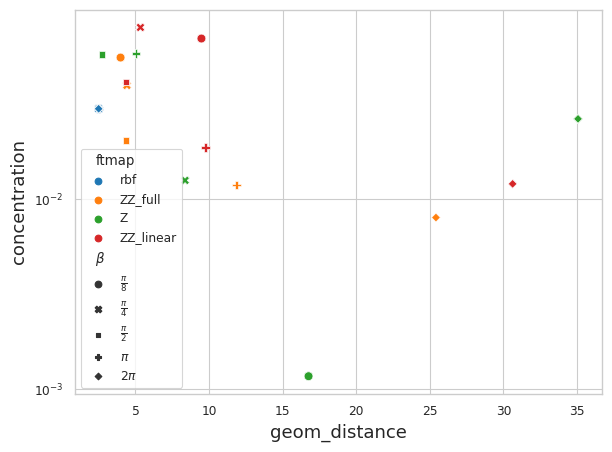

In [ ]:

sns.scatterplot(data=df, y='concentration',hue='ftmap',
                  x='geom_distance', style=r'$\beta$', markers=True, palette='tab10', s=40)
# Adjust the plot layout
#log scale
plt.yscale('log')
plt.tight_layout()
#plt.savefig(dir_paper+'{}_coherence.png'.format(score_to_plot), dpi=300)

# Show the plot
plt.show()

    

# Check Clustering correlation with other variables


In [ ]:
data_input

Component_1  Component_2  Component_3  Component_4  IntClustMemb
MB-4666     5.497749     4.056644     9.238402     3.813853             7
MB-2851     3.134798     3.639698    10.175092     2.422124             4
MB-5366     4.140319     3.347784     8.551789     3.669222             5
MB-5341     5.439688     4.379867     9.285794     3.870328             2
MB-0358     5.223124     3.096975     9.557095     2.317304             9
...              ...          ...          ...          ...           ...
MB-2849     3.129499     2.973610    10.085953     2.397814             9
MB-0022     4.345609     8.725343     6.175104    -0.403735             3
MB-4721     4.022290     4.786006     8.769722     4.222514             8
MB-5625     3.244882     1.117559     9.360249     3.188984             9
MB-5576     4.321651     3.904684     9.070042     2.413446             1

[1980 rows x 5 columns]

In [ ]:
quantumDf.set_index('PATIENT_ID',inplace=True)

In [ ]:
#Merge data_input with df_clust on index
df_new_clust=pd.merge(data_input.sample(n=1000,axis=0,random_state=42),quantumDf,how='left',left_index=True,right_index=True)
df_new_clust


Component_1  Component_2  Component_3  Component_4  IntClustMemb  \
MB-4270     4.459003     1.762128     8.716180     3.800151             9   
MB-6068     3.232354     0.750432     9.716409     3.052997             4   
MB-0666     4.351296     3.491412     9.277145     2.818116             9   
MB-7010     5.542212     4.578652     9.395142     3.620670             7   
MB-7036     3.751446     0.916476     9.636867     2.495010            10   
...              ...          ...          ...          ...           ...   
MB-3005     3.471740     4.602711     9.672564     2.170086             8   
MB-6024     3.996194     4.647072     8.249059     4.461824             8   
MB-0045     4.296920     1.071461     9.469940     2.832558             4   
MB-3430     3.837388     4.110645     8.960909     2.663787             3   
MB-5597     4.418150     4.273453     9.005754     3.333319             3   

         LYMPH_NODES_EXAMINED_POSITIVE    NPI CELLULARITY CHEMOTHERAPY  \
MB-4270                            4.0  5.036         NaN          YES   
MB-6068                            0.0  3.000    Moderate           NO   
MB-0666                            9.0  6.050        High          YES   
MB-7010                            0.0  2.046    Moderate           NO   
MB-7036                            2.0  5.036        High          YES   
...                                ...    ...         ...          ...   
MB-3005                            0.0  3.046    Moderate           NO   
MB-6024                            2.0  4.040    Moderate           NO   
MB-0045                            3.0  5.038        High          YES   
MB-3430                            1.0  5.050        High           NO   
MB-5597                            1.0  4.060    Moderate           NO   

         COHORT  ... Cluster_ZZ_linear_2_2 Cluster_ZZ_linear_3_2  \
MB-4270     3.0  ...                   0.0                   1.0   
MB-6068     5.0  ...                   0.0                   1.0   
MB-0666     1.0  ...                   1.0                   0.0   
MB-7010     4.0  ...                   0.0                   1.0   
MB-7036     4.0  ...                   1.0                   0.0   
...         ...  ...                   ...                   ...   
MB-3005     2.0  ...                   0.0                   2.0   
MB-6024     5.0  ...                   0.0                   1.0   
MB-0045     1.0  ...                   1.0                   1.0   
MB-3430     2.0  ...                   0.0                   2.0   
MB-5597     3.0  ...                   1.0                   1.0   

        Cluster_ZZ_linear_4_2 Cluster_ZZ_linear_5_2 Cluster_ZZ_linear_6_2  \
MB-4270                   3.0                   4.0                   0.0   
MB-6068                   2.0                   3.0                   5.0   
MB-0666                   1.0                   1.0                   4.0   
MB-7010                   1.0                   1.0                   5.0   
MB-7036                   0.0                   1.0                   4.0   
...                       ...                   ...                   ...   
MB-3005                   2.0                   2.0                   3.0   
MB-6024                   1.0                   0.0                   2.0   
MB-0045                   3.0                   0.0                   2.0   
MB-3430                   2.0                   3.0                   1.0   
MB-5597                   1.0                   0.0                   2.0   

        Cluster_ZZ_linear_7_2  Cluster_ZZ_linear_8_2  Cluster_ZZ_linear_9_2  \
MB-4270                   6.0                    7.0                    8.0   
MB-6068                   3.0                    3.0                    5.0   
MB-0666                   2.0                    0.0                    6.0   
MB-7010                   3.0                    3.0                    5.0   
MB-7036                   0.0                    2.0      

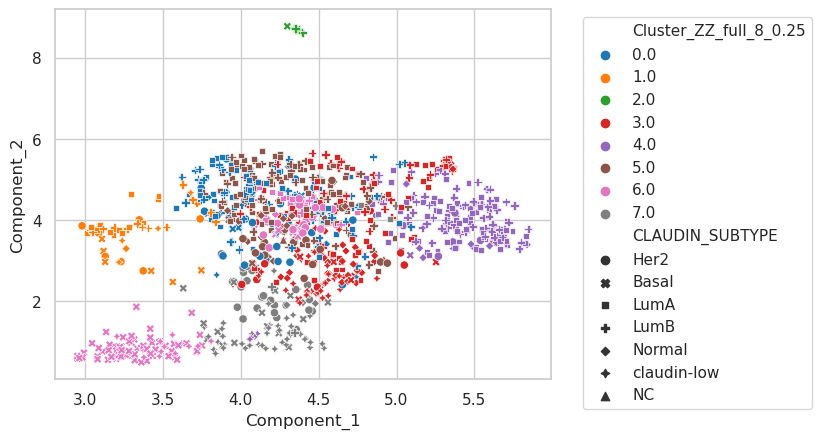

In [ ]:
sns.scatterplot(data=df_new_clust,
                x='Component_1',
                y='Component_2',
                hue='Cluster_ZZ_full_8_0.25',
                style='CLAUDIN_SUBTYPE',
                palette='tab10')
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

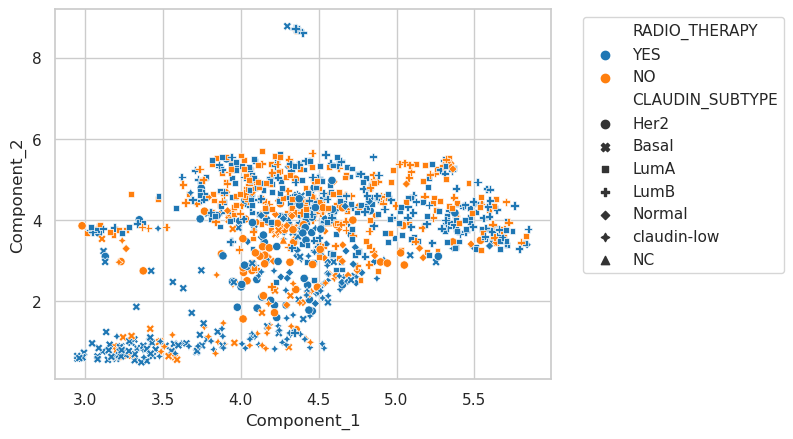

In [ ]:
sns.scatterplot(data=df_new_clust,
                x='Component_1',
                y='Component_2',
                hue='RADIO_THERAPY',
                style='CLAUDIN_SUBTYPE',
                palette='tab10')
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
df_new_clust['HORMONE_THERAPY'].value_counts()

HORMONE_THERAPY
YES    606
NO     394
Name: count, dtype: int64

In [ ]:
quantumDf.columns[:20]

Index(['LYMPH_NODES_EXAMINED_POSITIVE', 'NPI', 'CELLULARITY', 'CHEMOTHERAPY',
       'COHORT', 'ER_IHC', 'HER2_SNP6', 'HORMONE_THERAPY',
       'INFERRED_MENOPAUSAL_STATE', 'SEX', 'INTCLUST', 'AGE_AT_DIAGNOSIS',
       'OS_MONTHS', 'OS_STATUS', 'CLAUDIN_SUBTYPE', 'THREEGENE',
       'VITAL_STATUS', 'LATERALITY', 'RADIO_THERAPY', 'HISTOLOGICAL_SUBTYPE'],
      dtype='object')

In [ ]:
adjusted_mutual_info_score(df_new_clust['Cluster_ZZ_linear_8_0.25'],df_new_clust['SEX'])

0.0